# Imports + Import Data & Set Working Directory

In [1]:
#!/usr/bin/env Rscript

# Load libraries
require(ggplot2)
require(reshape2)

# Step 1: Read the CSV file
bids <- "/om2/user/mabdel03/files/Ravi_ISO_MRI/Final_Data/"
#read_csv <- file.path(bids, "code", "slm_data3.csv")
read_csv <- file.path("/om2/user/mabdel03/files/Ravi_ISO_MRI/Final_Data/code/slm_data3_with_qc.csv")
data <- read.csv(read_csv)
colnames <- names(data)

# Extract subsets with QC
fmri_data <- subset(data, fmri_qc == 1)
dwi_data <- subset(data, dwi_qc == 1)
anat_data <- subset(data, anat_qc == 1)

# Set working directory
setwd('/om2/user/mabdel03/files/Ravi_ISO_MRI/Mahmoud_Rerun_Model_Outputs')


Loading required package: ggplot2

Loading required package: reshape2



# Functions

In [2]:
#OLS Model w/ Interaction Terms, Filtering Output By Significance Threshold
run_ols_model <- function(dataframe, main_predictor, main_dependent, covariates_numeric = NULL, covariates_factor = NULL, interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001) {
  # Selecting relevant columns from the dataframe
  selected_vars <- c(main_predictor, main_dependent, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    interaction_vars <- unlist(strsplit(interaction_terms, ":"))
    selected_vars <- unique(c(selected_vars, interaction_vars))
  }
  data_subset <- dataframe[, selected_vars, drop = FALSE]
  
  # Remove rows with missing values
  data_subset <- na.omit(data_subset)
  
  # Z-scoring main predictor and dependent variable along with numeric covariates if they are not empty
  numeric_cols <- c(main_predictor, main_dependent, covariates_numeric)
  if (!is.null(numeric_cols)) {
    data_subset[numeric_cols] <- scale(data_subset[numeric_cols])
  }
  
  # Converting factor variables to factor type
  if (!is.null(covariates_factor)) {
    for (factor_var in covariates_factor) {
      data_subset[[factor_var]] <- factor(data_subset[[factor_var]])
    }
  }
  

  # Constructing the full model formula
  formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    formula_terms <- c(formula_terms, interaction_terms)
  }
  formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
  
  # Constructing the reduced model formula (excluding the main predictor)
  reduced_terms <- setdiff(formula_terms, c(main_predictor, interaction_terms))
  formula_string_reduced <- paste(main_dependent, "~", paste(reduced_terms, collapse = " + "))
  
  # Running the full OLS model
  ols_model_full <- lm(formula_string_full, data = data_subset)
  
  # Running the reduced OLS model
  ols_model_reduced <- lm(formula_string_reduced, data = data_subset)
  
  # Calculating adjusted R-squared for the full model
  adj_rsq_full <- summary(ols_model_full)$adj.r.squared
  
  # Calculating adjusted R-squared for the reduced model
  adj_rsq_reduced <- summary(ols_model_reduced)$adj.r.squared
  
  # Calculating change in adjusted R-squared
  delta_adj_rsq <- adj_rsq_full - adj_rsq_reduced
  
  # Extracting coefficients and p-values from the full model summary
  model_summary <- summary(ols_model_full)
  coefficients <- model_summary$coefficients
  p_value_main <- coefficients[main_predictor, "Pr(>|t|)"]
  
  # Extract p-value for interaction term if provided
  if (!is.null(interaction_terms)) {
    # Check if interaction term exists in coefficients
    interaction_exists <- interaction_terms %in% rownames(coefficients)
    if (any(interaction_exists)) {
      p_value_interaction <- coefficients[interaction_terms[interaction_exists], "Pr(>|t|)", drop = FALSE]
    } else {
      p_value_interaction <- NULL
    }
  } else {
    p_value_interaction <- NULL
  }
  
  # Only print if the main predictor is statistically significant
  if (p_value_main < significance_level) {
    cat("Formula (Full Model):", formula_string_full, "\n\n")
    cat("Significant Relationship between", main_dependent, "and", main_predictor, "with p-value:", p_value_main, "\n\n")
    print(coefficients[main_predictor, , drop = FALSE])
    
    # Also print the interaction term if it is provided and significant
    if (!is.null(p_value_interaction) && any(p_value_interaction < significance_level)) {
      cat("\nSignificant Interaction Terms:\n")
      print(coefficients[interaction_terms[interaction_exists], , drop = FALSE])
    }
    
    # Print the change in adjusted R-squared
    if (delta_adj_rsq > delta_rsq_threshold) {
      cat("\nRAW Adjusted R-squared:", adj_rsq_full, "\n\n")
      cat("\nChange in Adjusted R-squared (Full vs Reduced Model):", delta_adj_rsq, "\n\n")
    }
  }
    
  
  # Returning the OLS model object, p-values, and delta R-squared
  return(list(model = ols_model_full, p_value_main = p_value_main, p_value_interaction = p_value_interaction, delta_adj_rsq = delta_adj_rsq))
}


In [3]:
#OLS Model w/ Interaction Terms, Filtering Output By Significance Threshold
run_ols_model <- function(dataframe, main_predictor, main_dependent, covariates_numeric = NULL, covariates_factor = NULL, interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001) {
  # Selecting relevant columns from the dataframe
  selected_vars <- c(main_predictor, main_dependent, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    interaction_vars <- unlist(strsplit(interaction_terms, ":"))
    selected_vars <- unique(c(selected_vars, interaction_vars))
  }
  data_subset <- dataframe[, selected_vars, drop = FALSE]
  
  # Remove rows with missing values
  data_subset <- na.omit(data_subset)
  
  # Z-scoring main predictor and dependent variable along with numeric covariates if they are not empty
  numeric_cols <- c(main_predictor, main_dependent, covariates_numeric)
  if (!is.null(numeric_cols)) {
    data_subset[numeric_cols] <- scale(data_subset[numeric_cols])
  }
  
  # Converting factor variables to factor type
  if (!is.null(covariates_factor)) {
    for (factor_var in covariates_factor) {
      data_subset[[factor_var]] <- factor(data_subset[[factor_var]])
    }
  }
  

  # Constructing the full model formula
  formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    formula_terms <- c(formula_terms, interaction_terms)
  }
  formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
  
  # Constructing the reduced model formula (excluding the main predictor)
  reduced_terms <- setdiff(formula_terms, c(main_predictor, interaction_terms))
  formula_string_reduced <- paste(main_dependent, "~", paste(reduced_terms, collapse = " + "))
  
  # Running the full OLS model
  ols_model_full <- lm(formula_string_full, data = data_subset)
  
  # Running the reduced OLS model
  ols_model_reduced <- lm(formula_string_reduced, data = data_subset)
  
  # Calculating adjusted R-squared for the full model
  adj_rsq_full <- summary(ols_model_full)$adj.r.squared
  
  # Calculating adjusted R-squared for the reduced model
  adj_rsq_reduced <- summary(ols_model_reduced)$adj.r.squared
  
  # Calculating change in adjusted R-squared
  delta_adj_rsq <- adj_rsq_full - adj_rsq_reduced
  
  # Extracting coefficients and p-values from the full model summary
  model_summary <- summary(ols_model_full)
  coefficients <- model_summary$coefficients
  p_value_main <- coefficients[main_predictor, "Pr(>|t|)"]
  
  # Extract p-value for interaction term if provided
  if (!is.null(interaction_terms)) {
    # Check if interaction term exists in coefficients
    interaction_exists <- interaction_terms %in% rownames(coefficients)
    if (any(interaction_exists)) {
      p_value_interaction <- coefficients[interaction_terms[interaction_exists], "Pr(>|t|)", drop = FALSE]
    } else {
      p_value_interaction <- NULL
    }
  } else {
    p_value_interaction <- NULL
  }
  
  # Only print if the main predictor is statistically significant
  if (p_value_main < significance_level) {
    cat("Formula (Full Model):", formula_string_full, "\n\n")
    cat("Significant Relationship between", main_dependent, "and", main_predictor, "with p-value:", p_value_main, "\n\n")
    print(coefficients[main_predictor, , drop = FALSE])
    
    # Also print the interaction term if it is provided and significant
    if (!is.null(p_value_interaction) && any(p_value_interaction < significance_level)) {
      cat("\nSignificant Interaction Terms:\n")
      print(coefficients[interaction_terms[interaction_exists], , drop = FALSE])
    }
    
    # Print the change in adjusted R-squared
    if (delta_adj_rsq > delta_rsq_threshold) {
      cat("\nRAW Adjusted R-squared:", adj_rsq_full, "\n\n")
      cat("\nChange in Adjusted R-squared (Full vs Reduced Model):", delta_adj_rsq, "\n\n")
    }
  }
    
  
  # Returning the OLS model object, p-values, and delta R-squared
  return(list(model = ols_model_full, p_value_main = p_value_main, p_value_interaction = p_value_interaction, delta_adj_rsq = delta_adj_rsq))
}


In [4]:
run_ols_model_FDR <- function(dataframe, main_predictor, main_dependent, covariates_numeric = NULL, covariates_factor = NULL, interaction_terms = NULL, significance_level = 0.05, delta_rsq_threshold = 0.0001, external_p_values = NULL) {
  # Selecting relevant columns from the dataframe
  selected_vars <- c(main_predictor, main_dependent, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    interaction_vars <- unlist(strsplit(interaction_terms, ":"))
    selected_vars <- unique(c(selected_vars, interaction_vars))
  }
  data_subset <- dataframe[, selected_vars, drop = FALSE]
  
  # Remove rows with missing values
  data_subset <- na.omit(data_subset)
  
  # Z-scoring main predictor and dependent variable along with numeric covariates if they are not empty
  numeric_cols <- c(main_predictor, main_dependent, covariates_numeric)
  if (!is.null(numeric_cols)) {
    data_subset[numeric_cols] <- scale(data_subset[numeric_cols])
  }
  
  # Converting factor variables to factor type
  if (!is.null(covariates_factor)) {
    for (factor_var in covariates_factor) {
      data_subset[[factor_var]] <- factor(data_subset[[factor_var]])
    }
  }

  # Constructing the full model formula
  formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
  if (!is.null(interaction_terms)) {
    formula_terms <- c(formula_terms, interaction_terms)
  }
  formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
  
  # Constructing the reduced model formula (excluding the main predictor)
  reduced_terms <- setdiff(formula_terms, c(main_predictor, interaction_terms))
  formula_string_reduced <- paste(main_dependent, "~", paste(reduced_terms, collapse = " + "))
  
  # Running the full OLS model
  ols_model_full <- lm(formula_string_full, data = data_subset)
  
  # Running the reduced OLS model
  ols_model_reduced <- lm(formula_string_reduced, data = data_subset)
  
  # Calculating adjusted R-squared for the full model
  adj_rsq_full <- summary(ols_model_full)$adj.r.squared
  
  # Calculating adjusted R-squared for the reduced model
  adj_rsq_reduced <- summary(ols_model_reduced)$adj.r.squared
  
  # Calculating change in adjusted R-squared
  delta_adj_rsq <- adj_rsq_full - adj_rsq_reduced
  
  # Extracting coefficients and p-values from the full model summary
  model_summary <- summary(ols_model_full)
  coefficients <- model_summary$coefficients
  p_values <- coefficients[, "Pr(>|t|)"]
  
  # Combine external p-values with the model's p-values if provided
  if (!is.null(external_p_values)) {
    combined_p_values <- c(p_values, external_p_values)
  } else {
    combined_p_values <- p_values
  }
  
  # FDR correction for combined p-values
  p_values_fdr <- p.adjust(combined_p_values, method = "fdr")
  
  # Extract the FDR-corrected p-values for the main predictor and interaction terms
  p_value_main <- p_values_fdr[main_predictor]
  
  # Extract FDR-corrected p-value for interaction term if provided
  if (!is.null(interaction_terms)) {
    # Check if interaction term exists in coefficients
    interaction_exists <- interaction_terms %in% names(p_values_fdr)
    if (any(interaction_exists)) {
      p_value_interaction <- p_values_fdr[interaction_terms[interaction_exists], drop = FALSE]
    } else {
      p_value_interaction <- NULL
    }
  } else {
    p_value_interaction <- NULL
  }
  
  # Only print if the main predictor is statistically significant
  if (p_value_main < significance_level) {
    cat("Formula (Full Model):", formula_string_full, "\n\n")
    cat("Significant Relationship between", main_dependent, "and", main_predictor, "with FDR corrected p-value:", p_value_main, "\n\n")
    print(coefficients[main_predictor, , drop = FALSE])
    
    # Also print the interaction term if it is provided and significant
    if (!is.null(p_value_interaction) && any(p_value_interaction < significance_level)) {
      cat("\nSignificant Interaction Terms (FDR corrected):\n")
      print(coefficients[interaction_terms[interaction_exists], , drop = FALSE])
    }
    
    # Print the change in adjusted R-squared
    if (delta_adj_rsq >= delta_rsq_threshold) {
    cat("\nRAW Adjusted R-squared:", adj_rsq_full, "\n\n")
    cat("\nChange in Adjusted R-squared (Full vs Reduced Model):", delta_adj_rsq, "\n\n")
    }
  }
  
  # Returning the OLS model object, FDR corrected p-values, and delta R-squared
  return(list(model = ols_model_full, p_value_main_fdr = p_value_main, p_value_interaction_fdr = p_value_interaction, delta_adj_rsq = delta_adj_rsq))
}


# DWI Data

In [61]:
# Run a model
data_model <- dwi_data
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
    #covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- c('pheno_msex')
    #interaction <- c('pheno_msex', 'pheno_social_isolation')
    interaction <- c('pheno_social_isolation:pheno_msex')
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  interaction_terms = interaction)
    }
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*Vol"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]

Formula (Full Model): dwi_AAL_Frontal_Mid_Orb_L_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_white_matter_average_dti_fa + pheno_msex + pheno_social_isolation:pheno_msex 

Significant Relationship between dwi_AAL_Frontal_Mid_Orb_L_dti_fa and pheno_social_isolation with p-value: 0.02808871 

                          Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.09057987 0.04113806 -2.201851 0.02808871

RAW Adjusted R-squared: 0.3173917 


Change in Adjusted R-squared (Full vs Reduced Model): 0.00398406 

Formula (Full Model): dwi_AAL_Frontal_Mid_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_white_matter_average_dti_fa + pheno_msex + pheno_social_isolation:pheno_msex 

Significant Relationship between dwi_AAL_Frontal_Mid_Orb_R_dti_fa and pheno_social_isolation with p-value: 0.01938815 

                          Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.09797314 0.04178229 -2.344849 0.01938815

RAW Adjusted R

## Anatomical MRI Data

In [7]:
# Run a model
data_model <- anat_data
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*SurfArea*"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit","brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- c("pheno_msex")
    interaction <- c('pheno_social_isolation:pheno_msex')
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  interaction_terms = interaction,
                  significance_level = 0.05)
    }


## fMRI Data

In [8]:
# Run a model
data_model <- fmri_data
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- c("pheno_msex")
    interaction <- c('pheno_social_isolation:pheno_msex')
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  interaction_terms = interaction,
                  significance_level = 0.05)
    }

# Run Models On Dataset Split By Sex

## Subset Dataframes By Sex

In [2]:
dwi_data_male <- subset(dwi_data, pheno_msex == 1)
anat_data_male <- subset(anat_data, pheno_msex == 1)
fmri_data_male = subset(fmri_data, pheno_msex == 1)

In [3]:
dwi_data_female <- subset(dwi_data, pheno_msex == 0)
anat_data_female <- subset(anat_data, pheno_msex == 0)
fmri_data_female = subset(fmri_data, pheno_msex == 0)

## Male

### DWI

In [64]:
data_model <- dwi_data_male

In [52]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_male  # Ensure this dataframe is defined

# Loop through all columns in the dataframe
for (main_dependent in colnames(data_model)) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    # Run the OLS model
    tryCatch({
        model <- run_ols_model(
            dataframe = data_model,
            main_dependent = main_dependent,
            main_predictor = main_predictor,
            covariates_numeric = covariates_numeric,
            covariates_factor = covariates_factor
        )
        # Print or store model results as needed
    }, error = function(e) {
        #message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}


Skipping column 'subject' as it is not numeric



Formula (Full Model): pheno_cogn_global ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr 

Significant Relationship between pheno_cogn_global and pheno_social_isolation with p-value: 0.02756177 

                         Estimate Std. Error   t value   Pr(>|t|)
pheno_social_isolation -0.1758762 0.07891254 -2.228748 0.02756177

RAW Adjusted R-squared: 0.2208753 


Change in Adjusted R-squared (Full vs Reduced Model): 0.02377719 

Formula (Full Model): pheno_cesdsum ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr 

Significant Relationship between pheno_cesdsum and pheno_social_isolation with p-value: 6.838025e-07 

                        Estimate Std. Error  t value     Pr(>|t|)
pheno_social_isolation 0.4257457 0.08149963 5.223898 6.838025e-07

RAW Adjusted R-squared: 0.1689519 


Change in Adjusted R-squared (Full vs Reduced Model): 0.1680578 

Formula (Full Model): pheno_r_depres ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr 

Si

In [65]:
options(warn = -1)

In [69]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_male  # Ensure this dataframe is defined

filtered_columns <- grep("^dwi|^dti", colnames(data_model), value = TRUE)

num_metrics = 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)

    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))

    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    complete_data <- complete_data[complete.cases(complete_data), ]

    # Run the OLS model
    tryCatch({
        model <- lm(as.formula(formula_string_full), complete_data)
        model_summary <- summary(model)
        predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

        if (predictor_p_value <= 0.05) {
            #print(sprintf("Significant result for dependent variable: %s", main_dependent))
            #print(formula_string_full)
            result <- sub("^[^_]*_[^_]*_", "", main_dependent)
            print(paste(result, ': ', predictor_p_value))
            print(formula_string_full)
            #print(paste(main_dependent, ': ', predictor_p_value))
            num_metrics <- num_metrics + 1
            #print(model_summary)
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "Frontal_Sup_Orb_R_ad :  0.0167952436279339"
[1] "dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad"
[1] "Parietal_Sup_R_ad :  0.0477170432208961"
[1] "dwi_AAL_Parietal_Sup_R_ad ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad"
[1] "Parietal_Inf_R_dti_fa :  0.00721213990142848"
[1] "dwi_AAL_Parietal_Inf_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa"
[1] "Cerebelum_9_L_dti_fa :  0.00670838177350307"
[1] "dwi_AAL_Cerebelum_9_L_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa"
[1] "Frontal_Sup_Orb_R_md :  0.0171769686278779"
[1] "dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md"
[1] "Pallidum_L_qa :  0.0350211037603029"
[1] "dwi_AAL_Pallidum_L_qa ~ pheno_social_isolation 

In [67]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_male  # Ensure this dataframe is defined

filtered_columns <- grep("^dwi|^dti", colnames(data_model), value = TRUE)

num_metrics = 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)

    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))

    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    complete_data <- complete_data[complete.cases(complete_data), ]

    # Run the OLS model
    tryCatch({
        model <- lm(as.formula(formula_string_full), complete_data)
        model_summary <- summary(model)
        predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

        if (0.05 < predictor_p_value & predictor_p_value <= 0.09) {
            #print(sprintf("Significant result for dependent variable: %s", main_dependent))
            #print(formula_string_full)
            result <- sub("^[^_]*_[^_]*_", "", main_dependent)
            print(paste(result, ': ', predictor_p_value))
            #print(paste(main_dependent, ': ', predictor_p_value))
            num_metrics <- num_metrics + 1
            #print(model_summary)
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)

[1] "Rectus_L_ad :  0.0837182051037133"
[1] "Vermis_8_ad :  0.0617225651467989"
[1] "Occipital_Inf_R_dti_fa :  0.0631364297903713"
[1] "Pallidum_L_dti_fa :  0.0888029851848657"
[1] "Cerebelum_Crus1_L_dti_fa :  0.0878047223553367"
[1] "Cerebelum_8_L_dti_fa :  0.0880774420127881"
[1] "Vermis_1_2_dti_fa :  0.0866874409598673"
[1] "Parietal_Sup_R_md :  0.0515960682315954"
[1] "Vermis_8_md :  0.0616855971389345"
[1] "Fusiform_L_qa :  0.0764144740718155"
[1] "Vermis_1_2_qa :  0.063873751738823"
[1] "Parietal_Sup_R_rd :  0.0575610068128989"
[1] "Vermis_8_rd :  0.0629799113566381"
[1] "Fasciculus_L_elongation :  0.0529876185923953"
[1] "Fasciculus_L_trunk_volume_mm3 :  0.0584414384012362"
[1] "Fasciculus_R_mean_length_mm :  0.0516858209767958"
[1] "Fronto_Occipital_Fasciculus_L_curl :  0.0769506245110432"
[1] "Fronto_Occipital_Fasciculus_R_mean_length_mm :  0.0617900416225808"
[1] "Longitudinal_Fasciculus_R_qa :  0.0543767434917022"
[1] "Longitudinal_Fasciculus1_L_dti_fa :  0.0624488573281415"

### Anatomical MRI

In [16]:
# Significant Results Across All DWI Measures
data_model <- anat_data_male  # Ensure this dataframe is defined

# Select relevant columns
filtered_columns <- grep("^regionsurfacestats|^brainmeasures", colnames(data_model), value = TRUE)

num_metrics <- 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
    
    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    
    # Ensure all columns are numeric and contain finite values
    complete_data <- complete_data[complete.cases(complete_data), ]  # Remove rows with NA
    complete_data <- complete_data[apply(complete_data, 1, function(row) all(is.finite(row))), ]  # Remove NaN/Inf
    
    # Ensure the dependent variable has no NA/NaN/Inf
    if (!all(is.finite(complete_data[[main_dependent]]))) {
        message(sprintf("Skipping column '%s' due to NA/NaN/Inf in dependent variable", main_dependent))
        next
    }
    
    # Run the OLS model
    tryCatch({
        if (nrow(complete_data) > 0) {  # Ensure there is enough data
            model <- lm(as.formula(formula_string_full), complete_data)
            model_summary <- summary(model)
            predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

            if (!is.na(predictor_p_value) && predictor_p_value <= 0.05) {
                #result <- sub("^[^_]*_[^_]*_", "", main_dependent)
                print(paste(main_dependent, ': ', predictor_p_value))
                num_metrics <- num_metrics + 1
            }
        } else {
            message(sprintf("Insufficient data for column '%s'", main_dependent))
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "brainmeasures_Third_Ventricle_NVoxels :  0.0136293503590011"
[1] "brainmeasures_CSF_NVoxels :  0.0135837759666407"
[1] "brainmeasures_CC_Anterior_NVoxels :  0.0328131191650158"
[1] "brainmeasures_Third_Ventricle_Volume_mm3 :  0.0139720941441333"
[1] "brainmeasures_CSF_Volume_mm3 :  0.0250236107329253"
[1] "brainmeasures_CC_Anterior_Volume_mm3 :  0.0458862768743499"
[1] "brainmeasures_Right_vessel_normMean :  0.0424381988414895"
[1] "brainmeasures_CC_Mid_Anterior_normMean :  0.0260342370884672"
[1] "brainmeasures_Left_Inf_Lat_Vent_normStdDev :  0.0288627888140739"
[1] "brainmeasures_Right_Thalamus_normStdDev :  0.024336824089706"
[1] "brainmeasures_Right_Hippocampus_normStdDev :  0.03386559721473"
[1] "brainmeasures_Right_vessel_normStdDev :  0.0300122140005364"
[1] "brainmeasures_Right_Thalamus_normMin :  0.00906318846298391"
[1] "brainmeasures_Right_Putamen_normMin :  0.0479886985509286"
[1] "brainmeasures_Right_Hippocampus_normMin :  0.0463455955155262"
[1] "brainmeasures_Right_

In [17]:
# Significant Results Across All DWI Measures
data_model <- anat_data_male  # Ensure this dataframe is defined

# Select relevant columns
filtered_columns <- grep("^regionsurfacestats|^brainmeasures", colnames(data_model), value = TRUE)

num_metrics <- 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
    
    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    
    # Ensure all columns are numeric and contain finite values
    complete_data <- complete_data[complete.cases(complete_data), ]  # Remove rows with NA
    complete_data <- complete_data[apply(complete_data, 1, function(row) all(is.finite(row))), ]  # Remove NaN/Inf
    
    # Ensure the dependent variable has no NA/NaN/Inf
    if (!all(is.finite(complete_data[[main_dependent]]))) {
        message(sprintf("Skipping column '%s' due to NA/NaN/Inf in dependent variable", main_dependent))
        next
    }
    
    # Run the OLS model
    tryCatch({
        if (nrow(complete_data) > 0) {  # Ensure there is enough data
            model <- lm(as.formula(formula_string_full), complete_data)
            model_summary <- summary(model)
            predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

            if (!is.na(predictor_p_value) && (0.05 < predictor_p_value & predictor_p_value <= 0.09)) {
                #result <- sub("^[^_]*_[^_]*_", "", main_dependent)
                print(paste(main_dependent, ': ', predictor_p_value))
                num_metrics <- num_metrics + 1
            }
        } else {
            message(sprintf("Insufficient data for column '%s'", main_dependent))
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "brainmeasures_Left_Caudate_NVoxels :  0.0597664980631146"
[1] "brainmeasures_Right_Inf_Lat_Vent_NVoxels :  0.0593796389267966"
[1] "brainmeasures_Right_vessel_NVoxels :  0.0807636197501193"
[1] "brainmeasures_Right_Inf_Lat_Vent_Volume_mm3 :  0.0648705732073857"
[1] "brainmeasures_Right_vessel_Volume_mm3 :  0.0845299299687882"
[1] "brainmeasures_CC_Central_Volume_mm3 :  0.0667503667642428"
[1] "brainmeasures_Right_Inf_Lat_Vent_normMean :  0.0823652214886302"
[1] "brainmeasures_Third_Ventricle_normStdDev :  0.0530696568789841"
[1] "brainmeasures_Right_VentralDC_normStdDev :  0.0670047075239609"
[1] "brainmeasures_CC_Posterior_normStdDev :  0.0829376455748664"
[1] "brainmeasures_Right_vessel_normMin :  0.0807927273406665"
[1] "brainmeasures_Right_Hippocampus_normRange :  0.0546151119906774"
[1] "regionsurfacestats_AAL_lh_Frontal_Sup_Orb_L_GausCurv :  0.0663845976913079"
[1] "regionsurfacestats_AAL_lh_Frontal_Inf_Orb_L_CurvInd :  0.0758261042575029"
[1] "regionsurfacestats_AAL_lh_Fron

### fMRI

In [24]:
# Run a model
data_model <- fmri_data_male
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
p_values_list <- list()
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    p_values_list[[main_dependent]] <- model$p_value_main
    
    }

Formula (Full Model): bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Med_Orb_R_t1t2ratio and pheno_social_isolation with p-value: 0.01572837 

                        Estimate Std. Error  t value   Pr(>|t|)
pheno_social_isolation 0.2413736 0.09821818 2.457525 0.01572837

RAW Adjusted R-squared: 0.08894666 


Change in Adjusted R-squared (Full vs Reduced Model): 0.04591187 



In [15]:
# Significant Results Across All DWI Measures
data_model <- fmri_data_male  # Ensure this dataframe is defined

# Select relevant columns
filtered_columns <- grep("^bold", colnames(data_model), value = TRUE)

num_metrics <- 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit")
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
    
    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    
    # Ensure only complete and finite cases are used
    complete_data <- complete_data[complete.cases(complete_data), ]
    complete_data <- complete_data[sapply(complete_data, function(x) all(is.finite(x))), ]
    
    # Run the OLS model
    tryCatch({
        if (nrow(complete_data) > 0) {  # Ensure there is enough data
            model <- lm(as.formula(formula_string_full), complete_data)
            model_summary <- summary(model)
            predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

            if (!is.na(predictor_p_value) && predictor_p_value <= 0.05) {
                #result <- sub("^[^_]*_[^_]*_", "", main_dependent)
                print(paste(main_dependent, ': ', predictor_p_value))
                num_metrics <- num_metrics + 1
            }
        } else {
            message(sprintf("Insufficient data for column '%s'", main_dependent))
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "bold_AAL_Rectus_R_alff :  0.0467636550452386"
[1] "bold_AAL_Cerebelum_3_L_alff :  0.039378930509796"
[1] "bold_AAL_Vermis_1_2_alff :  0.015547643211689"
[1] "bold_AAL_Frontal_Med_Orb_R_t1t2ratio :  0.0157283685109375"
[1] "bold_AAL_Cingulum_Ant_R_t1t2ratio :  0.0196303833884097"
[1] 5


In [18]:
# Significant Results Across All DWI Measures
data_model <- fmri_data_male  # Ensure this dataframe is defined

# Select relevant columns
filtered_columns <- grep("^bold", colnames(data_model), value = TRUE)

num_metrics <- 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit")
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)
    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))
    
    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    
    # Ensure only complete and finite cases are used
    complete_data <- complete_data[complete.cases(complete_data), ]
    complete_data <- complete_data[sapply(complete_data, function(x) all(is.finite(x))), ]
    
    # Run the OLS model
    tryCatch({
        if (nrow(complete_data) > 0) {  # Ensure there is enough data
            model <- lm(as.formula(formula_string_full), complete_data)
            model_summary <- summary(model)
            predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

            if (!is.na(predictor_p_value) && (0.05 < predictor_p_value & predictor_p_value <= 0.09)) {
                #result <- sub("^[^_]*_[^_]*_", "", main_dependent)
                print(paste(main_dependent, ': ', predictor_p_value))
                num_metrics <- num_metrics + 1
            }
        } else {
            message(sprintf("Insufficient data for column '%s'", main_dependent))
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "bold_AAL_Occipital_Sup_R_alff :  0.0614737767316619"
[1] "bold_AAL_Frontal_Inf_Tri_L_t1t2ratio :  0.0631217411280773"
[1] 2


## Females

### DWI

In [ ]:
# Run a model
data_model <- dwi_data_female
string_to_match <- "dwi.*AAL.*Frontal.*_dti_fa"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit", "dwi_white_matter_average_dti_fa")
    #covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor)
    }

In [19]:
# Significant Results Across All DWI Measures
data_model <- dwi_data_female  # Ensure this dataframe is defined

filtered_columns <- grep("^dwi|^dti", colnames(data_model), value = TRUE)

num_metrics = 0

# Loop through all columns in the dataframe
for (main_dependent in filtered_columns) {
    # Check if the column is numeric; if not, skip to the next iteration
    if (!is.numeric(data_model[[main_dependent]])) {
        message(sprintf("Skipping column '%s' as it is not numeric", main_dependent))
        next
    }
    
    # Define main predictor
    main_predictor <- "pheno_social_isolation"
    
    # Determine covariates_numeric based on the column name
    covariates_numeric <- c("pheno_age_at_visit", "dwi_neighbor_corr")  # Always include this as the first covariate
    if (grepl("ad$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_ad")
    } else if (grepl("fa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_dti_fa")
    } else if (grepl("md$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_md")
    } else if (grepl("qa$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_qa")
    } else if (grepl("rd$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "dwi_white_matter_average_rd")
    } else if (grepl("_length_mm$|_span_mm$|_curl$|_elongation$|_diameter_mm$|_volume_mm3$|_trunk_volume_mm3$|_branch_volume_mm3$|_total_surface_area_mm2$", main_dependent)) {
        covariates_numeric <- c(covariates_numeric, "brainmeasures_CerebralWhiteMatter_CerebralWhiteMatterVol")
    }
    
    # Define covariates_factor (if applicable)
    covariates_factor <- NULL  # Adjust if needed for your use case

    formula_terms <- c(main_predictor, covariates_numeric, covariates_factor)

    formula_string_full <- paste(main_dependent, "~", paste(formula_terms, collapse = " + "))

    # Subset data to remove rows with missing or invalid values
    complete_data <- data_model[, c(main_dependent, main_predictor, covariates_numeric)]
    complete_data <- complete_data[complete.cases(complete_data), ]

    # Run the OLS model
    tryCatch({
        model <- lm(as.formula(formula_string_full), complete_data)
        model_summary <- summary(model)
        predictor_p_value <- coef(model_summary)[main_predictor, "Pr(>|t|)"]

        if (predictor_p_value <= 0.05) {
            #print(sprintf("Significant result for dependent variable: %s", main_dependent))
            #print(formula_string_full)
            result <- sub("^[^_]*_[^_]*_", "", main_dependent)
            print(paste(result, ': ', predictor_p_value))
            #print(paste(main_dependent, ': ', predictor_p_value))
            num_metrics <- num_metrics + 1
            #print(model_summary)
        }
    }, error = function(e) {
        message(sprintf("Error running model for column '%s': %s", main_dependent, e$message))
    })
}

print(num_metrics)


[1] "Rolandic_Oper_L_ad :  0.000219867732744627"
[1] "Rolandic_Oper_R_ad :  0.0101987735793022"
[1] "Olfactory_L_ad :  0.00430546812641179"
[1] "Rectus_L_ad :  0.0441438112563414"
[1] "Insula_L_ad :  0.00079120996892748"
[1] "Insula_R_ad :  0.000161794804269096"
[1] "Hippocampus_L_ad :  0.000285452956418966"
[1] "Hippocampus_R_ad :  0.000433587112299852"
[1] "ParaHippocampal_L_ad :  0.00387929371026727"
[1] "ParaHippocampal_R_ad :  0.00541941081479455"
[1] "Amygdala_L_ad :  0.00117804713869709"
[1] "Amygdala_R_ad :  0.00296445525391933"
[1] "Fusiform_L_ad :  0.026519776195904"
[1] "Fusiform_R_ad :  0.00736783545518802"
[1] "Thalamus_L_ad :  0.00695311963280466"
[1] "Thalamus_R_ad :  0.00598550790545657"
[1] "Heschl_L_ad :  0.000161536303734801"
[1] "Heschl_R_ad :  0.000570928695999992"
[1] "Temporal_Sup_L_ad :  0.00298614012706195"
[1] "Temporal_Sup_R_ad :  0.00257464788862759"
[1] "Temporal_Pole_Sup_L_ad :  0.0116102891439683"
[1] "Temporal_Pole_Sup_R_ad :  0.0363133178741129"
[1] "Te

### Anatomical MRI

In [9]:
# Run a model
data_model <- anat_data_female
string_to_match <- "regionsurfacestats.*AAL.*Frontal.*SurfArea*"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit","brainmeasures_EstimatedTotalIntraCranialVol_eTIV")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    }


### fMRI

In [28]:
# Run a model
data_model <- fmri_data_female
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
p_values_list <- list()
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    p_values_list[[main_dependent]] <- model$p_value_main
    
    }

In [29]:
filtered_p_values <- p_values_list[grep("Med", names(p_values_list))]
print(filtered_p_values)

$bold_AAL_Frontal_Sup_Medial_L_t1t2ratio
[1] 0.2018895

$bold_AAL_Frontal_Sup_Medial_R_t1t2ratio
[1] 0.1952962

$bold_AAL_Frontal_Med_Orb_L_t1t2ratio
[1] 0.6601218

$bold_AAL_Frontal_Med_Orb_R_t1t2ratio
[1] 0.8970751



In [30]:
# Run a model
data_model <- fmri_data_female
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    run_ols_model <- run_ols_model_FDR(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor, 
                  interaction_terms = NULL, significance_level = 1.0, delta_rsq_threshold = 0.0000)
    }

Formula (Full Model): bold_AAL_Frontal_Sup_L_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_L_t1t2ratio and pheno_social_isolation with FDR corrected p-value: 1 

                           Estimate Std. Error    t value  Pr(>|t|)
pheno_social_isolation -0.009249295 0.05964156 -0.1550814 0.8768643
Formula (Full Model): bold_AAL_Frontal_Sup_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_R_t1t2ratio and pheno_social_isolation with FDR corrected p-value: 1 

                          Estimate Std. Error   t value  Pr(>|t|)
pheno_social_isolation 0.008431606 0.05918923 0.1424517 0.8868215
Formula (Full Model): bold_AAL_Frontal_Sup_Orb_L_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit 

Significant Relationship between bold_AAL_Frontal_Sup_Orb_L_t1t2ratio and pheno_social_isolation with FDR corrected p-value: 1 

                           Estimate Std.

In [10]:
# Run a model
data_model <- fmri_data_female
string_to_match <- "bold.*Frontal.*t1t2ratio"
columns_match <- names(data_model)[grep(string_to_match, colnames(data_model))]
for (main_dependent in columns_match) {
    main_predictor <- "pheno_social_isolation"
    covariates_numeric <- c("pheno_age_at_visit")
    covariates_factor <- NULL
    model <- run_ols_model(dataframe=data_model,
                  main_dependent = main_dependent,
                  main_predictor = main_predictor,
                  covariates_numeric = covariates_numeric,
                  covariates_factor = covariates_factor,
                  significance_level = 0.05)
    }

# Old Test Visuals

In [8]:
install.packages("kableExtra")

also installing the dependency ‘svglite’




In [9]:
library(kableExtra)

# Create a data frame for the table
df <- data.frame(
  Term = "pheno_social_isolation",
  Estimate = 0.2413736,
  Std_Error = 0.09821818,
  t_value = 2.457525,
  Pr = 0.01572837
)

# Format the table
kable(df, format = "html", caption = "Model Summary") %>%
  kable_styling(full_width = F) %>%
  add_header_above(c(" " = 1, "Coefficients" = 4))

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>Model Summary</caption>
 <thead>
<tr>
<th style="empty-cells: hide;border-bottom:hidden;" colspan="1"></th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; " colspan="4"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">Coefficients</div></th>
</tr>
  <tr>
   <th style="text-align:left;"> Term </th>
   <th style="text-align:right;"> Estimate </th>
   <th style="text-align:right;"> Std_Error </th>
   <th style="text-align:right;"> t_value </th>
   <th style="text-align:right;"> Pr </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> pheno_social_isolation </td>
   <td style="text-align:right;"> 0.2413736 </td>
   <td style="text-align:right;"> 0.0982182 </td>
   <td style="text-align:right;"> 2.457525 </td>
   <td style="text-align:right;"> 0.0157284 </td>
  </tr>
</tbody>
</table>

In [10]:
# Fit the model
model <- lm(bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit, data = fmri_data_male)

Warning message in abline(model, col = "red"):
“only using the first two of 3 regression coefficients”


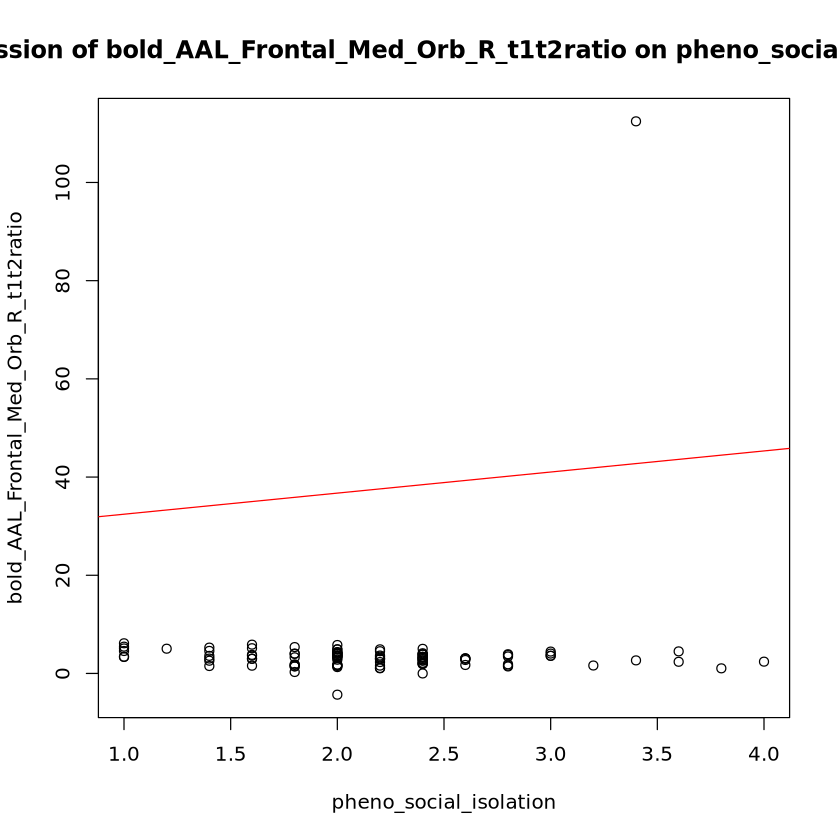

In [11]:
plot(fmri_data_male$pheno_social_isolation, fmri_data_male$bold_AAL_Frontal_Med_Orb_R_t1t2ratio, 
     main = "Regression of bold_AAL_Frontal_Med_Orb_R_t1t2ratio on pheno_social_isolation",
     xlab = "pheno_social_isolation", 
     ylab = "bold_AAL_Frontal_Med_Orb_R_t1t2ratio")
abline(model, col = "red")

`geom_smooth()` using formula = 'y ~ x'


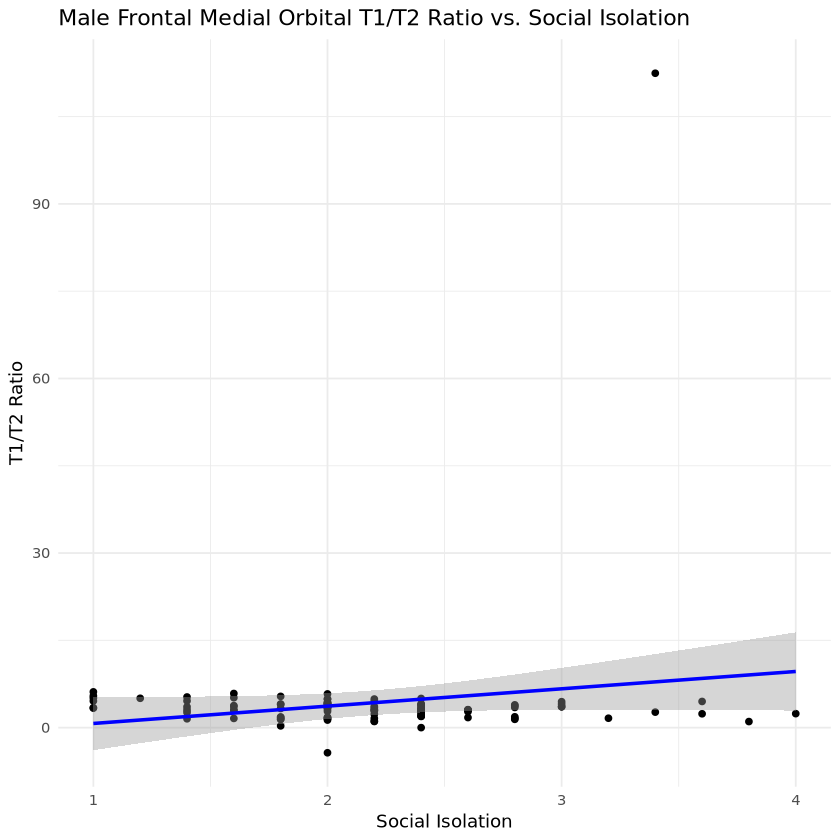

In [15]:
# Plot using ggplot2
ggplot(fmri_data_male, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


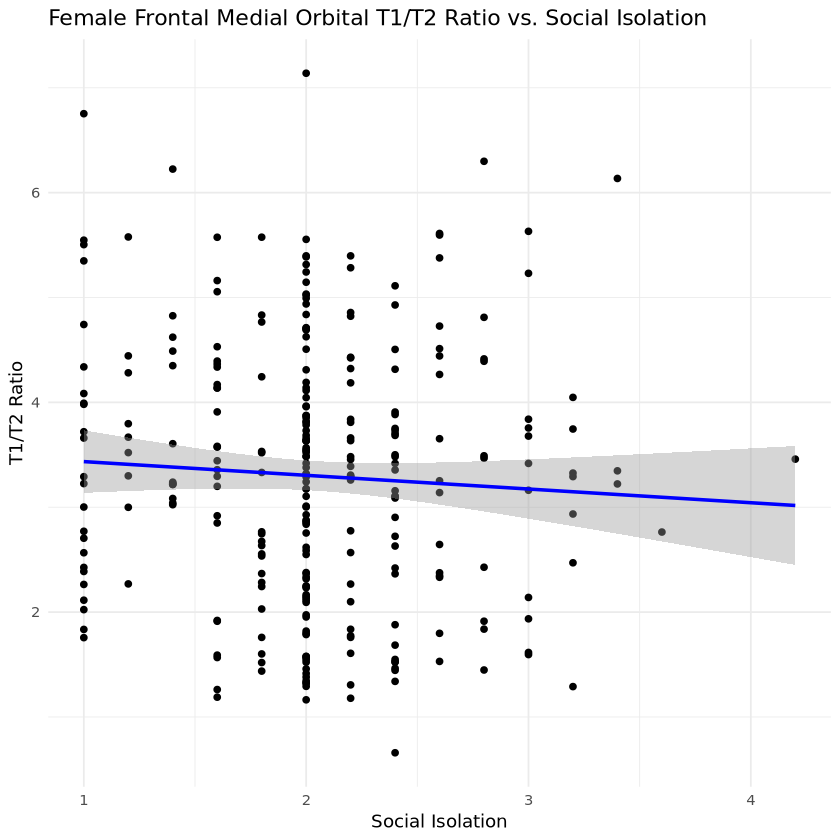

In [16]:
# Plot using ggplot2
ggplot(fmri_data_female, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Female Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()


In [17]:
# Subset the data frame based on the threshold
no_outliers_male <- fmri_data_male[fmri_data_male$bold_AAL_Frontal_Med_Orb_R_t1t2ratio < 10, ]

In [19]:
# Subset the data frame based on the threshold
no_outliers_female <- fmri_data_female[fmri_data_female$bold_AAL_Frontal_Med_Orb_R_t1t2ratio < 10, ]

`geom_smooth()` using formula = 'y ~ x'


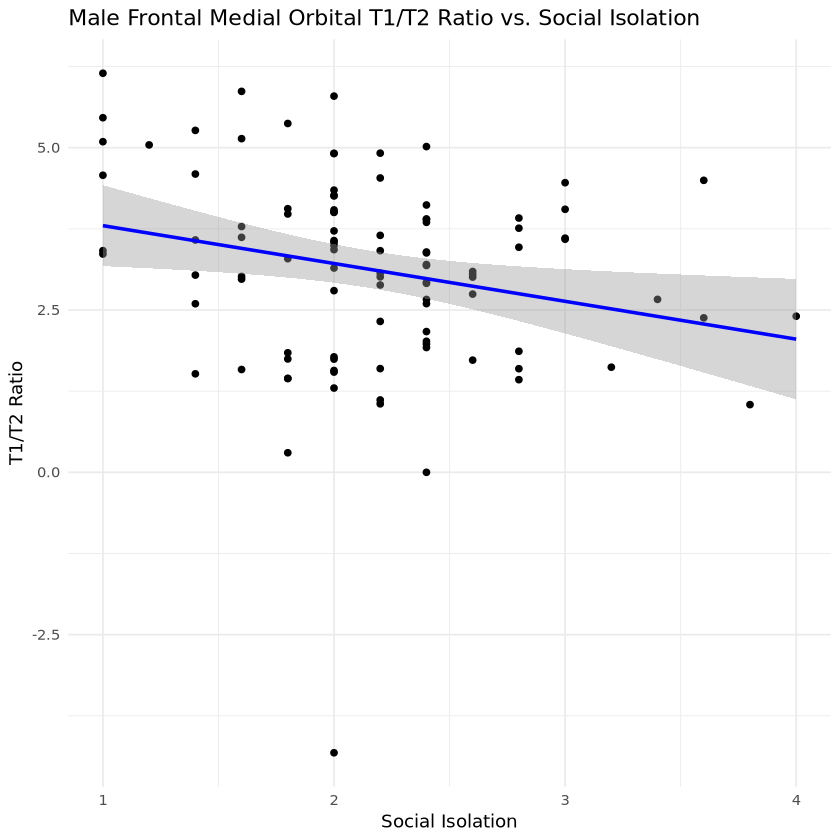

In [18]:
# Plot using ggplot2
ggplot(no_outliers_male, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


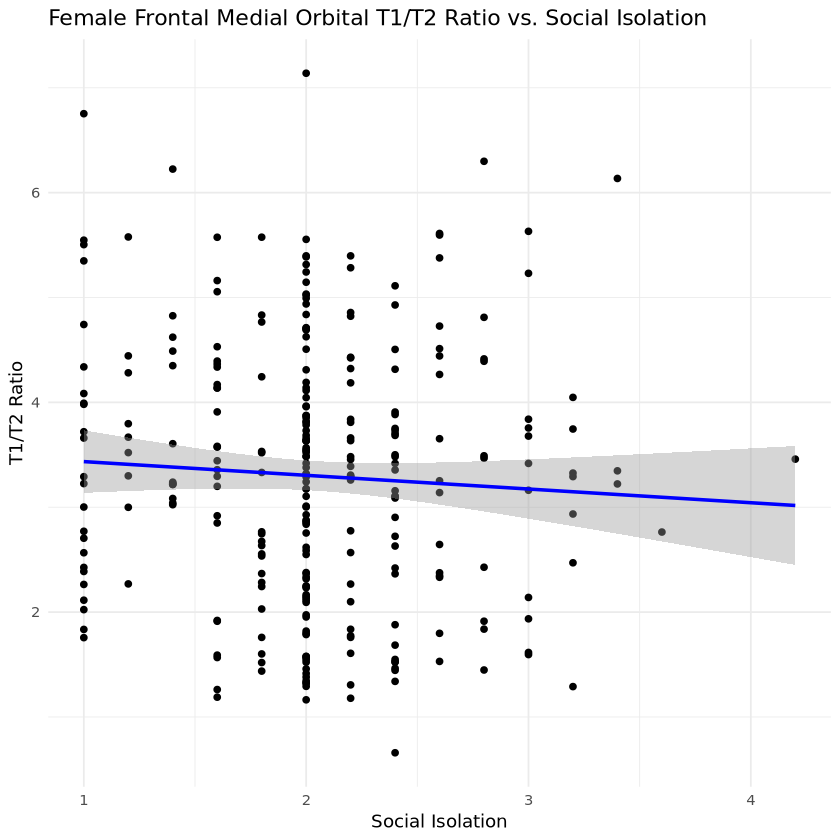

In [20]:
# Plot using ggplot2
ggplot(no_outliers_female, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Female Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()

In [26]:
fmri_data_male['bold_AAL_Frontal_Med_Orb_R_t1t2ratio']

,bold_AAL_Frontal_Med_Orb_R_t1t2ratio
,<dbl>
1,3.016433
20,3.037712
29,2.797823
40,5.793920
42,4.346113
44,4.497026
45,4.003023
61,3.413632
68,1.426750


In [27]:
fmri_data_female['bold_AAL_Frontal_Med_Orb_R_t1t2ratio']

,bold_AAL_Frontal_Med_Orb_R_t1t2ratio
,<dbl>
2,1.380575
3,2.316938
4,4.190729
6,3.548432
7,5.283615
8,2.644875
9,5.397075
10,4.414710
13,3.217794


In [28]:
install.packages("modelsummary")

also installing the dependencies ‘bayestestR’, ‘datawizard’, ‘checkmate’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’, ‘tinytable’




In [29]:
model <- lm(bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit, data = no_outliers_male)

In [30]:
library(modelsummary)
modelsummary(model)

`modelsummary` 2.0.0 now uses `tinytable` as its default table-drawing
  backend. Learn more at: https://vincentarelbundock.github.io/tinytable/

Revert to `kableExtra` for one session:

  options(modelsummary_factory_default = 'kableExtra')
  options(modelsummary_factory_latex = 'kableExtra')
  options(modelsummary_factory_html = 'kableExtra')

Silence this message forever:

  config_modelsummary(startup_message = FALSE)




+------------------------+----------+
|                        | (1)      |
+========================+==========+
| (Intercept)            | 7.840    |
+------------------------+----------+
|                        | (1.521)  |
+------------------------+----------+
| pheno_social_isolation | -0.400   |
+------------------------+----------+
|                        | (0.247)  |
+------------------------+----------+
| pheno_age_at_visit     | -0.048   |
+------------------------+----------+
|                        | (0.020)  |
+------------------------+----------+
| Num.Obs.               | 101      |
+------------------------+----------+
| R2                     | 0.109    |
+------------------------+----------+
| R2 Adj.                | 0.091    |
+------------------------+----------+
| AIC                    | 362.8    |
+------------------------+----------+
| BIC                    | 373.3    |
+------------------------+----------+
| Log.Lik.               | -177.412 |
+----------

In [31]:
kableExtra::kable(x = broom::tidy(model), format = "pipe")



|term                   |   estimate| std.error| statistic|   p.value|
|:----------------------|----------:|---------:|---------:|---------:|
|(Intercept)            |  7.8397461| 1.5211207|  5.153928| 0.0000013|
|pheno_social_isolation | -0.3999190| 0.2472145| -1.617700| 0.1089416|
|pheno_age_at_visit     | -0.0476333| 0.0196553| -2.423432| 0.0172094|

In [34]:
install.packages("webshot2")

also installing the dependencies ‘AsioHeaders’, ‘websocket’, ‘chromote’




In [32]:
# Install phantomjs if it's not already installed
webshot::install_phantomjs()

# Fit a model (for example purposes)
model <- lm(mpg ~ cyl + hp, data = mtcars)

# Create the table using kableExtra
table_html <- kableExtra::kable(x = broom::tidy(model), format = "html") %>%
  kable_styling(bootstrap_options = "striped", full_width = F)

# Save the table as an HTML file
save_kable(table_html, "table.html")

# Convert the HTML to a PNG using webshot
webshot2::webshot("table.html", file = "table.png")

ERROR: Error in loadNamespace(x): there is no package called ‘webshot’


# Final Paper Visuals

## Males Only

### Diffusivity Metrics

#### Axial Diffusivity (AD)

In [89]:
model_full_ad <- lm('dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad', dwi_data_male)
model_red_ad <- lm('dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad', dwi_data_male)

In [90]:
summary(model_full_ad)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20397 -0.06590 -0.00598  0.04239  0.48083 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.121430   1.296744  -0.094  0.92554    
pheno_social_isolation       0.036014   0.014864   2.423  0.01680 *  
pheno_age_at_visit           0.005140   0.001528   3.365  0.00101 ** 
dwi_neighbor_corr           -0.407092   1.466401  -0.278  0.78176    
dwi_white_matter_average_ad  1.155370   0.261807   4.413 2.14e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1042 on 128 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.3964,	Adjusted R-squared:  0.3775 
F-statistic: 21.01 on 4 and 128 DF,  p-value: 2.459e-13


In [93]:
# Delta Adjusted R^2
summary(model_full_ad)$adj.r.squared - summary(model_red_ad)$adj.r.squared

[1] 0.02884329

`geom_smooth()` using formula = 'y ~ x'


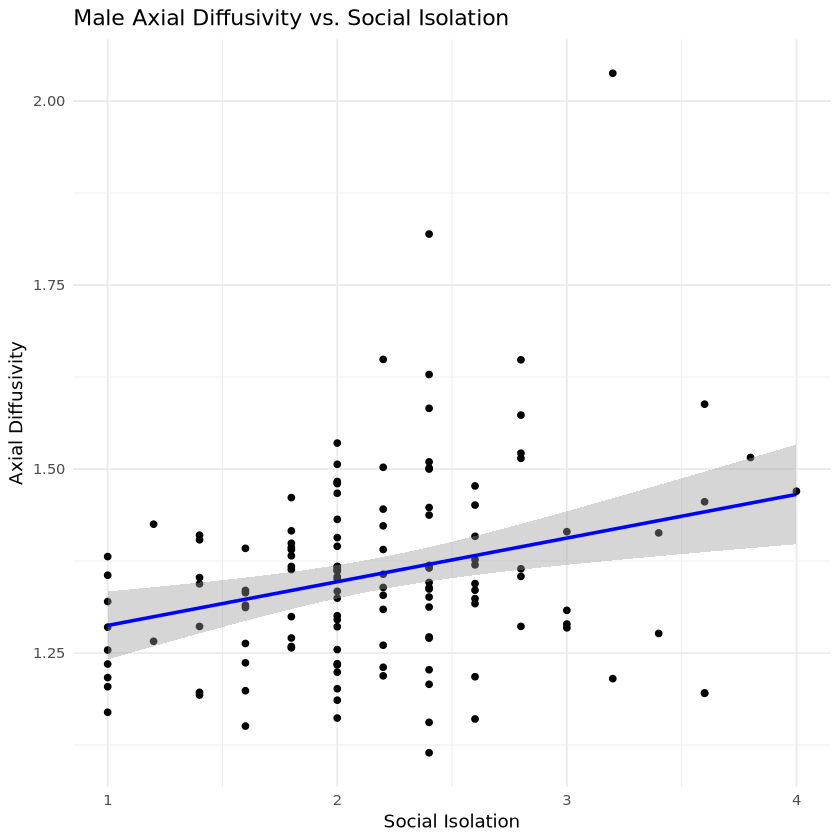

In [73]:
# Plot using ggplot2
ggplot(dwi_data_male, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_ad)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Axial Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Axial Diffusivity") +
  theme_minimal()

#### Mean Diffusivity (MD)

In [ ]:
# Callosum_Forceps_Minor

In [6]:
model_full_md <- lm('dwi_Corpus_Callosum_Forceps_Minor_rd ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md', dwi_data_male)
model_red_md <- lm('dwi_Corpus_Callosum_Forceps_Minor_rd ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md', dwi_data_male)

In [7]:
summary(model_full_md)


Call:
lm(formula = "dwi_Corpus_Callosum_Forceps_Minor_rd ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17414 -0.03952 -0.01143  0.03223  0.21817 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -1.607202   0.789975  -2.034  0.04397 *  
pheno_social_isolation       0.018790   0.009019   2.083  0.03921 *  
pheno_age_at_visit           0.002598   0.000883   2.942  0.00387 ** 
dwi_neighbor_corr            1.487679   0.896132   1.660  0.09934 .  
dwi_white_matter_average_md  0.939470   0.137531   6.831 3.06e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06316 on 128 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.5014,	Adjusted R-squared:  0.4858 
F-statistic: 32.18 on 4 and 128 DF,  p-value: <

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


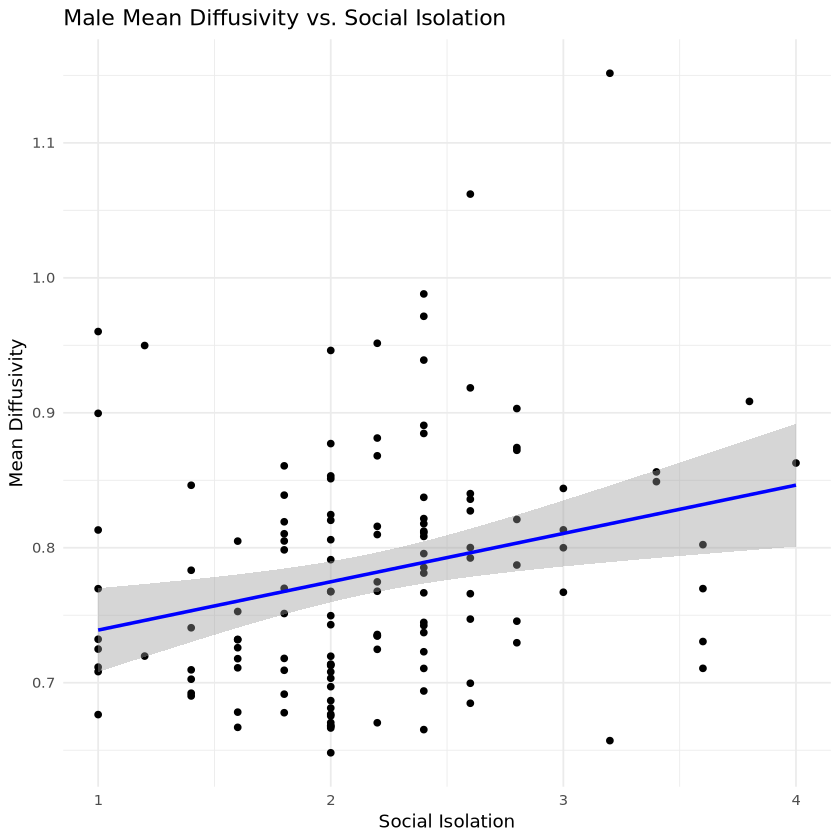

In [9]:
# Plot using ggplot2
ggplot(dwi_data_male, aes(x = pheno_social_isolation, y = dwi_Corpus_Callosum_Forceps_Minor_rd)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Mean Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Mean Diffusivity") +
  theme_minimal()

In [14]:
# Subset the dataframe
dwi_data_male_highRD <- dwi_data_male[
  dwi_data_male$dwi_Corpus_Callosum_Forceps_Minor_rd > 0.9 & 
  dwi_data_male$pheno_social_isolation > 3, 
]

In [15]:
dwi_data_male_highRD

,subject,fmri_qc,dwi_qc,anat_qc,has_pheno,pheno_fu_year,pheno_age_at_visit,pheno_cogn_global,pheno_cesdsum,pheno_r_depres,⋯,bold_AAL_Vermis_4_5_t1t2ratio,bold_AAL_Vermis_6_t1t2ratio,bold_AAL_Vermis_7_t1t2ratio,bold_AAL_Vermis_8_t1t2ratio,bold_AAL_Vermis_9_t1t2ratio,bold_AAL_Vermis_10_t1t2ratio,anat_xgbscore,dwi_neighbor_corr,bold_fd_mean,bold_n_outliers
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
349,sub-64925372,1,1,1,1,3,92.39973,-0.8087659,4,4,⋯,3.288091,2.805398,2.4091883,2.475142,2.8979257,1.3186488,0.97058880,0.907374,0.2503402,23
536,sub-94549523,1,1,0,1,0,92.19165,0.3730942,5,3,⋯,1.270641,1.079676,0.9295547,1.004611,0.9475953,0.5531596,0.04823902,0.910526,0.2241277,28


In [20]:
dwi_data_male_highRD$pheno_social_isolation

[1] 3.2 3.8

In [19]:
dwi_data_male_highRD$dwi_Corpus_Callosum_Forceps_Minor_rd

[1] 1.151580 0.908443

In [16]:
# Subset the dataframe
dwi_data_male_lowhRD <- dwi_data_male[
  dwi_data_male$dwi_Corpus_Callosum_Forceps_Minor_rd < 0.7 & 
  dwi_data_male$pheno_social_isolation < 1.5, 
]

In [17]:
dwi_data_male_lowhRD

,subject,fmri_qc,dwi_qc,anat_qc,has_pheno,pheno_fu_year,pheno_age_at_visit,pheno_cogn_global,pheno_cesdsum,pheno_r_depres,⋯,bold_AAL_Vermis_4_5_t1t2ratio,bold_AAL_Vermis_6_t1t2ratio,bold_AAL_Vermis_7_t1t2ratio,bold_AAL_Vermis_8_t1t2ratio,bold_AAL_Vermis_9_t1t2ratio,bold_AAL_Vermis_10_t1t2ratio,anat_xgbscore,dwi_neighbor_corr,bold_fd_mean,bold_n_outliers
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,sub-04984547,1,1,1,1,2,79.54004,0.4525766,0,4,⋯,3.073079,5.675804,3.532770,2.807880,2.761052,1.874465,0.9045482,0.900598,0.17200744,7
308,sub-56961563,0,1,1,1,2,82.86927,0.6082513,0,4,⋯,3.059357,3.017919,3.175098,3.153900,3.048698,2.138247,0.8667103,0.905143,0.29964152,39
417,sub-75161029,1,1,1,1,1,79.95346,0.2140553,0,4,⋯,4.269112,4.573368,4.328548,3.822603,3.851590,3.100820,0.9795293,0.909292,0.07519714,1


In [21]:
dwi_data_male_lowhRD$pheno_social_isolation

[1] 1.4 1.0 1.4

In [22]:
dwi_data_male_lowhRD$dwi_Corpus_Callosum_Forceps_Minor_rd

[1] 0.690195 0.676393 0.692264

In [96]:
model_full_md <- lm('dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md', dwi_data_male)
model_red_md <- lm('dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md', dwi_data_male)

In [97]:
summary(model_full_md)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20144 -0.05919 -0.00398  0.04846  0.35844 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.969688   1.198872   0.809 0.420112    
pheno_social_isolation       0.033047   0.013688   2.414 0.017177 *  
pheno_age_at_visit           0.004776   0.001340   3.564 0.000514 ***
dwi_neighbor_corr           -1.330983   1.359975  -0.979 0.329583    
dwi_white_matter_average_md  1.131179   0.208717   5.420 2.86e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09585 on 128 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.4269,	Adjusted R-squared:  0.4089 
F-statistic: 23.83 on 4 and 128 DF,  p-value: 9.571e-15

In [98]:
# Delta Adjusted R^2
summary(model_full_md)$adj.r.squared - summary(model_red_md)$adj.r.squared

[1] 0.02990544

`geom_smooth()` using formula = 'y ~ x'


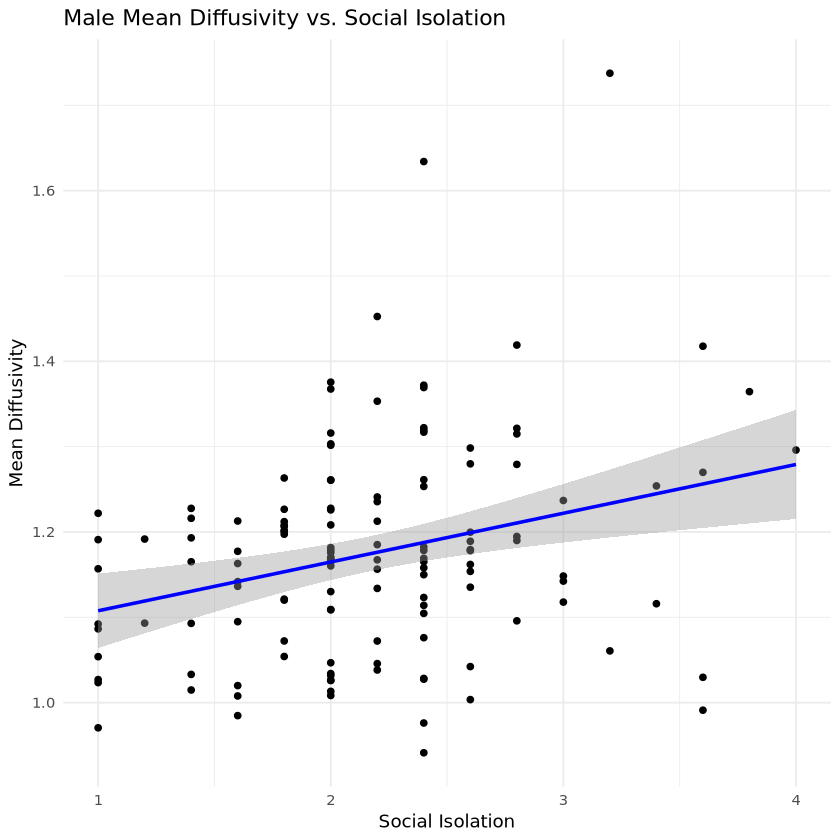

In [77]:
# Plot using ggplot2
ggplot(dwi_data_male, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_md)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Mean Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Mean Diffusivity") +
  theme_minimal()

#### Radial Diffusivity (RD)

In [94]:
model_full_rd <- lm('dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_rd', dwi_data_male)
model_red_rd <- lm('dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_rd', dwi_data_male)

In [95]:
summary(model_full_rd)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_rd", 
    data = dwi_data_male)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.20353 -0.05986 -0.00585  0.04785  0.36135 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.471098   1.184204   1.242 0.216409    
pheno_social_isolation       0.031723   0.013449   2.359 0.019848 *  
pheno_age_at_visit           0.004688   0.001288   3.640 0.000394 ***
dwi_neighbor_corr           -1.733985   1.339058  -1.295 0.197676    
dwi_white_matter_average_rd  1.084897   0.187851   5.775 5.51e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09413 on 128 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.4306,	Adjusted R-squared:  0.4128 
F-statistic:  24.2 on 4 and 128 DF,  p-value: 6.323e-15

In [99]:
# Delta Adjusted R^2
summary(model_full_rd)$adj.r.squared - summary(model_red_rd)$adj.r.squared

[1] 0.02904541

`geom_smooth()` using formula = 'y ~ x'


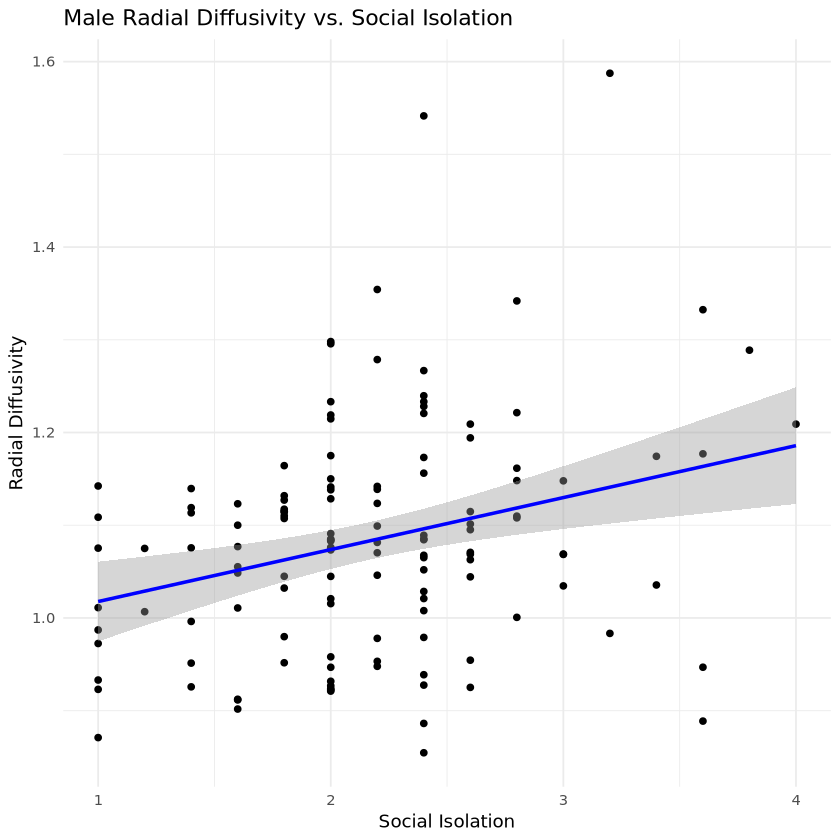

In [101]:
# Plot using ggplot2
ggplot(dwi_data_male, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_rd)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Radial Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Radial Diffusivity") +
  theme_minimal()

#### Fractional Anisotropy

In [119]:
model_full_fa <- lm('dwi_AAL_Frontal_Sup_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa', dwi_data_male)
model_red_fa <- lm('dwi_AAL_Frontal_Sup_Orb_R_dti_fa ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa', dwi_data_male)

In [120]:
summary(model_full_fa)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa", 
    data = dwi_data_male)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.027959 -0.011088 -0.003405  0.011141  0.053252 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -0.4387307  0.2247184  -1.952   0.0531 .  
pheno_social_isolation          -0.0034399  0.0024260  -1.418   0.1586    
pheno_age_at_visit              -0.0003627  0.0002158  -1.681   0.0952 .  
dwi_neighbor_corr                0.5363662  0.2410060   2.226   0.0278 *  
dwi_white_matter_average_dti_fa  0.4548408  0.0749115   6.072 1.34e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01691 on 128 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2972,	Adjusted R-squared:  0.2752 
F-stati

In [114]:
# Delta Adjusted R^2
summary(model_full_fa)$adj.r.squared - summary(model_red_fa)$adj.r.squared

[1] 0.007868186

`geom_smooth()` using formula = 'y ~ x'


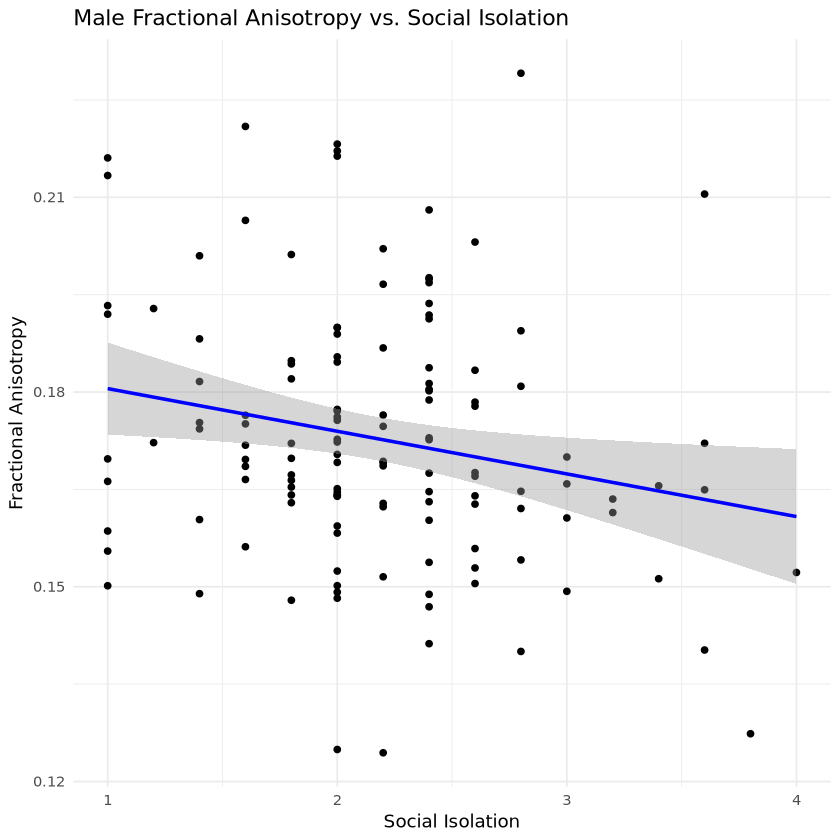

In [115]:
# Plot using ggplot2
ggplot(dwi_data_male, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_dti_fa)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Fractional Anisotropy vs. Social Isolation",
       x = "Social Isolation", 
       y = "Fractional Anisotropy") +
  theme_minimal()

#### FDR Correction

In [121]:
# List in order corresponds to (dwi_AAL_Frontal_Sup_Orb_R_ad, dwi_AAL_Frontal_Sup_Orb_R_md, dwi_AAL_Frontal_Sup_Orb_R_rd, dwi_AAL_Frontal_Sup_Orb_R_dti_fa)
p_values <- c(0.01680, 0.017177, 0.019848, 0.1586)

# FDR correction using Benjamini-Hochberg method
fdr_corrected <- p.adjust(p_values, method = "fdr")

# Output the FDR corrected p-value for the first p-value
fdr_corrected

[1] 0.026464 0.026464 0.026464 0.158600

### T1T2 Ratio Metrics

In [39]:
fmri_data_male_no_outliers <- subset(
  fmri_data_male,
  bold_AAL_Frontal_Med_Orb_R_t1t2ratio <= 80
)

In [171]:
model_full <- lm('bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit', fmri_data_male)
model_red <- lm('bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_age_at_visit', fmri_data_male)

In [172]:
summary(model_full)


Call:
lm(formula = "bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit", 
    data = fmri_data_male)

Residuals:
   Min     1Q Median     3Q    Max 
-9.548 -3.475 -0.766  1.473 96.867 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)   
(Intercept)             28.1432    10.9572   2.568  0.01171 * 
pheno_social_isolation   4.2963     1.7482   2.458  0.01573 * 
pheno_age_at_visit      -0.4121     0.1392  -2.959  0.00386 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.43 on 99 degrees of freedom
Multiple R-squared:  0.107,	Adjusted R-squared:  0.08895 
F-statistic:  5.93 on 2 and 99 DF,  p-value: 0.003694


In [174]:
# Delta Adjusted R^2
summary(model_full)$adj.r.squared - summary(model_red)$adj.r.squared

[1] 0.04591187

`geom_smooth()` using formula = 'y ~ x'


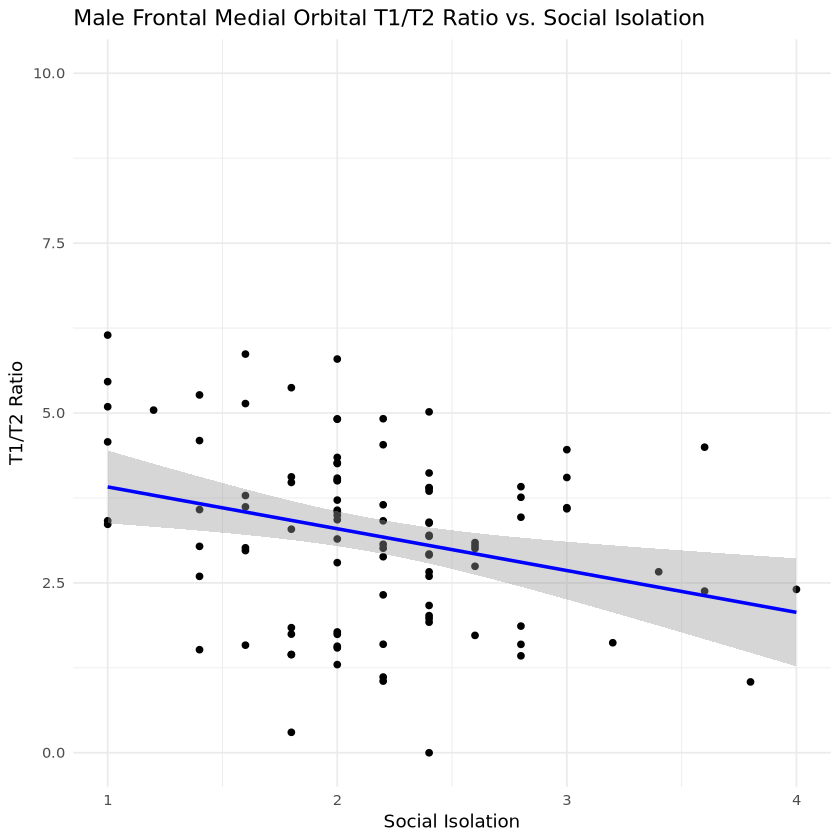

In [176]:
# Plot using ggplot2
ggplot(fmri_data_male, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "blue") +  # Add regression line
  labs(title = "Male Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal() +
  ylim(0, 10)  # Restrict the y-axis range


## Females Only

### Diffusivity Metrics

#### Axial Diffusivity (AD)

In [123]:
model_full_ad <- lm('dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad', dwi_data_female)
model_red_ad <- lm('dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad', dwi_data_female)

In [124]:
summary(model_full_ad)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_ad ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_ad", 
    data = dwi_data_female)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21731 -0.07071 -0.00608  0.05881  0.45964 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -1.2574225  0.6199689  -2.028   0.0432 *  
pheno_social_isolation       0.0096902  0.0084868   1.142   0.2542    
pheno_age_at_visit           0.0018233  0.0008421   2.165   0.0309 *  
dwi_neighbor_corr            0.9281462  0.6713582   1.382   0.1676    
dwi_white_matter_average_ad  1.3647348  0.1523567   8.957   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1016 on 420 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.3014,	Adjusted R-squared:  0.2947 
F-statistic: 45.29 on 4 and 420 DF,  p-value: < 

In [125]:
# Delta Adjusted R^2
summary(model_full_ad)$adj.r.squared - summary(model_red_ad)$adj.r.squared

[1] -0.001110287

`geom_smooth()` using formula = 'y ~ x'


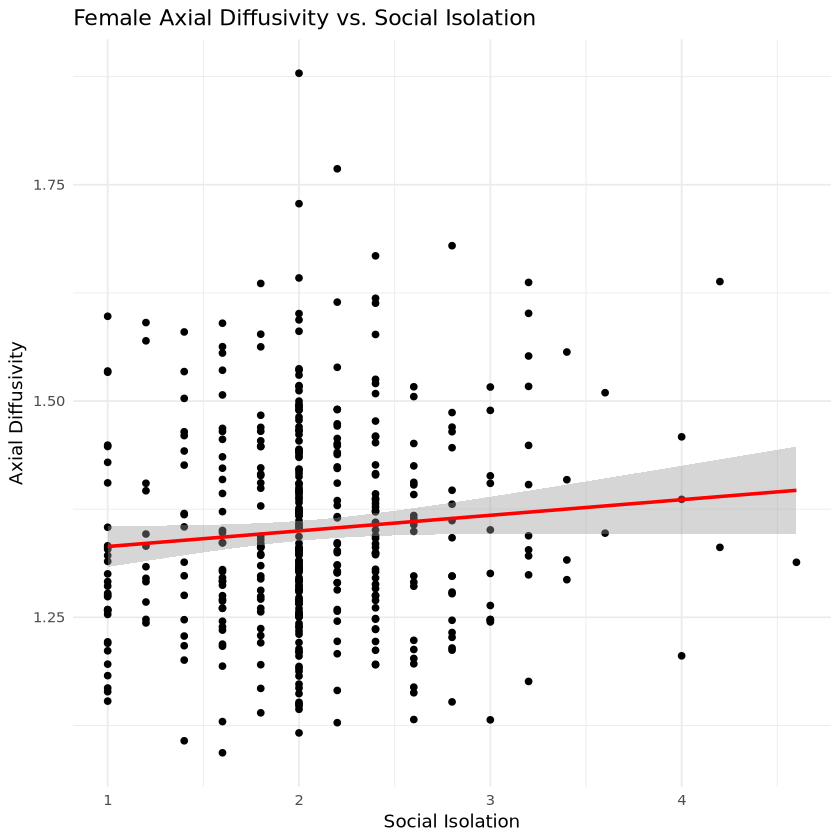

In [143]:
# Plot using ggplot2
ggplot(dwi_data_female, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_ad)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "red") +  # Add regression line
  labs(title = "Female Axial Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Axial Diffusivity") +
  theme_minimal()

#### Mean Diffusivity (MD)

In [128]:
model_full_md <- lm('dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md', dwi_data_female)
model_red_md <- lm('dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md', dwi_data_female)

In [129]:
summary(model_full_md)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_md ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_md", 
    data = dwi_data_female)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.22768 -0.06568 -0.00661  0.05477  0.38287 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.7838800  0.5785933  -1.355   0.1762    
pheno_social_isolation       0.0093226  0.0080659   1.156   0.2484    
pheno_age_at_visit           0.0019905  0.0007898   2.520   0.0121 *  
dwi_neighbor_corr            0.7743681  0.6393890   1.211   0.2265    
dwi_white_matter_average_md  1.2755526  0.1369512   9.314   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09658 on 420 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.3205,	Adjusted R-squared:  0.3141 
F-statistic: 49.53 on 4 and 420 DF,  p-value: <

In [130]:
# Delta Adjusted R^2
summary(model_full_md)$adj.r.squared - summary(model_red_md)$adj.r.squared

[1] -0.0009592924

`geom_smooth()` using formula = 'y ~ x'


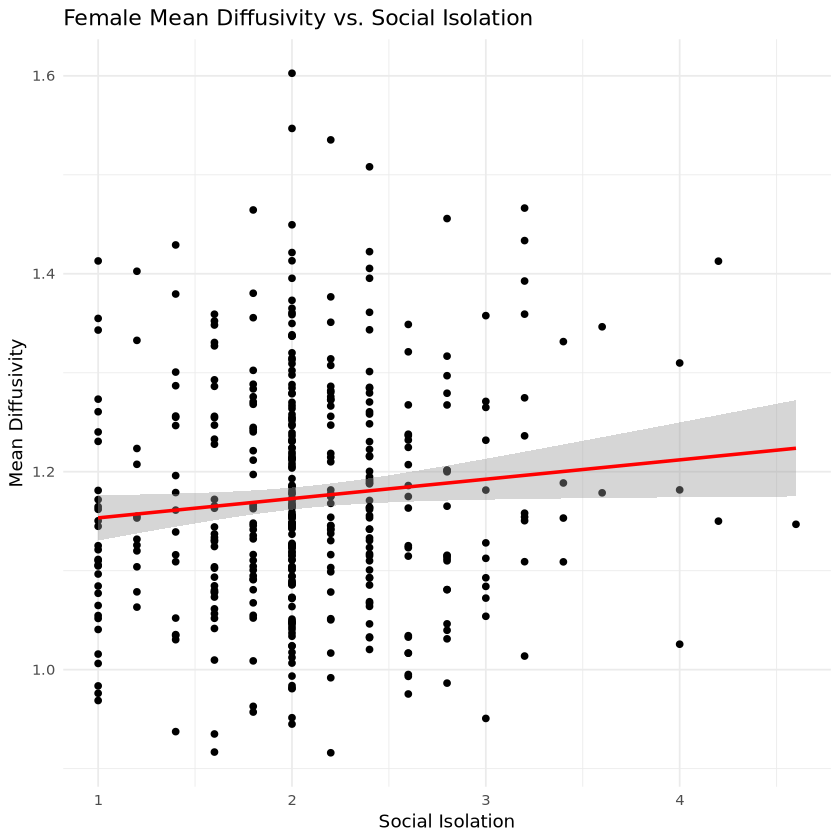

In [142]:
# Plot using ggplot2
ggplot(dwi_data_female, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_md)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "red") +  # Add regression line
  labs(title = "Female Mean Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Mean Diffusivity") +
  theme_minimal()

#### Radial Diffusivity (RD)

In [132]:
model_full_rd <- lm('dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_rd', dwi_data_female)
model_red_rd <- lm('dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_rd', dwi_data_female)

In [133]:
summary(model_full_rd)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_rd ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_rd", 
    data = dwi_data_female)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24999 -0.06338 -0.00656  0.05754  0.34277 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.5778530  0.5708776  -1.012  0.31202    
pheno_social_isolation       0.0092458  0.0079818   1.158  0.24737    
pheno_age_at_visit           0.0022223  0.0007682   2.893  0.00402 ** 
dwi_neighbor_corr            0.7252110  0.6333955   1.145  0.25288    
dwi_white_matter_average_rd  1.1890534  0.1276365   9.316  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09557 on 420 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.3231,	Adjusted R-squared:  0.3166 
F-statistic: 50.11 on 4 and 420 DF,  p-value: <

In [134]:
# Delta Adjusted R^2
summary(model_full_rd)$adj.r.squared - summary(model_red_rd)$adj.r.squared

[1] -0.0008957149

`geom_smooth()` using formula = 'y ~ x'


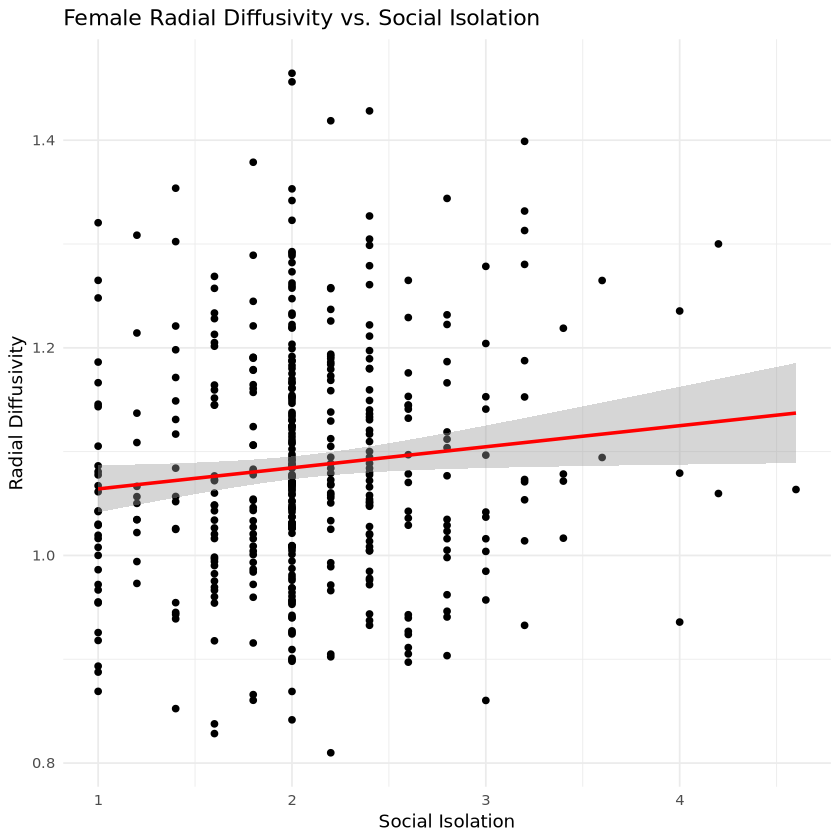

In [141]:
# Plot using ggplot2
ggplot(dwi_data_female, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_rd)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "red") +  # Add regression line
  labs(title = "Female Radial Diffusivity vs. Social Isolation",
       x = "Social Isolation", 
       y = "Radial Diffusivity") +
  theme_minimal()

#### Fractional Anisotropy

In [136]:
model_full_fa <- lm('dwi_AAL_Frontal_Sup_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa', dwi_data_female)
model_red_fa <- lm('dwi_AAL_Frontal_Sup_Orb_R_dti_fa ~ pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa', dwi_data_female)

In [137]:
summary(model_full_fa)


Call:
lm(formula = "dwi_AAL_Frontal_Sup_Orb_R_dti_fa ~ pheno_social_isolation + pheno_age_at_visit + dwi_neighbor_corr + dwi_white_matter_average_dti_fa", 
    data = dwi_data_female)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040683 -0.010498 -0.000722  0.008160  0.067989 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.1604868  0.0974958   1.646  0.10049    
pheno_social_isolation          -0.0022636  0.0012985  -1.743  0.08203 .  
pheno_age_at_visit              -0.0003355  0.0001126  -2.980  0.00305 ** 
dwi_neighbor_corr               -0.1125322  0.1033284  -1.089  0.27675    
dwi_white_matter_average_dti_fa  0.3977528  0.0449524   8.848  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01554 on 420 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.2595,	Adjusted R-squared:  0.2525 
F-sta

In [138]:
# Delta Adjusted R^2
summary(model_full_fa)$adj.r.squared - summary(model_red_fa)$adj.r.squared

[1] 0.002688301

`geom_smooth()` using formula = 'y ~ x'


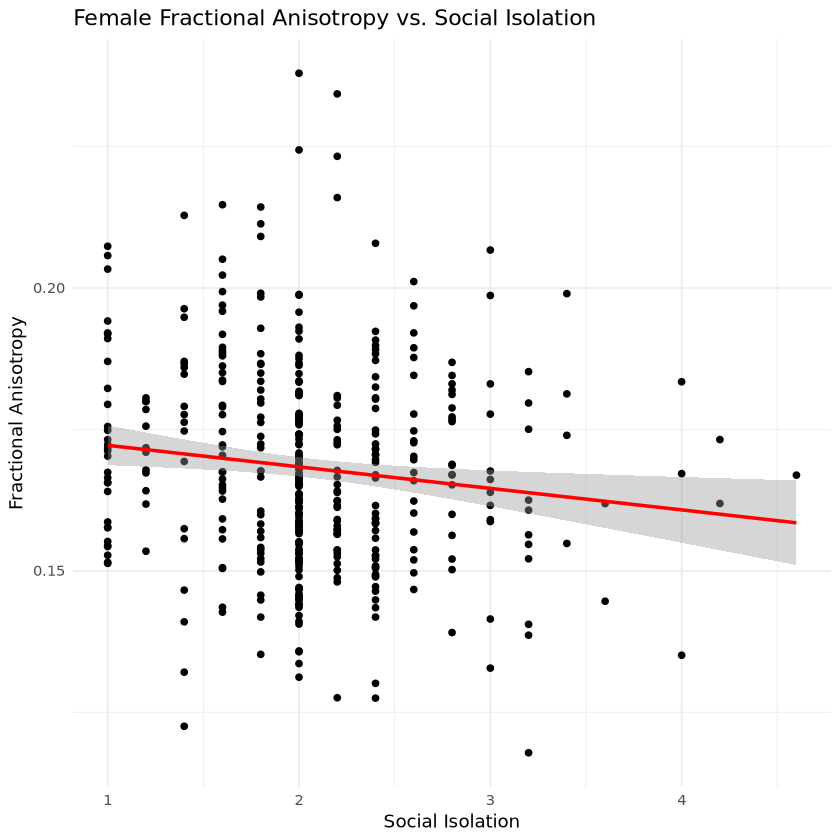

In [140]:
# Plot using ggplot2
ggplot(dwi_data_female, aes(x = pheno_social_isolation, y = dwi_AAL_Frontal_Sup_Orb_R_dti_fa)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "red") +  # Add regression line
  labs(title = "Female Fractional Anisotropy vs. Social Isolation",
       x = "Social Isolation", 
       y = "Fractional Anisotropy") +
  theme_minimal()

#### FDR Correction

In [144]:
# List in order corresponds to (dwi_AAL_Frontal_Sup_Orb_R_ad, dwi_AAL_Frontal_Sup_Orb_R_md, dwi_AAL_Frontal_Sup_Orb_R_rd, dwi_AAL_Frontal_Sup_Orb_R_dti_fa)
p_values <- c(0.2542, 0.2484, 0.24737, 0.08203)

# FDR correction using Benjamini-Hochberg method
fdr_corrected <- p.adjust(p_values, method = "fdr")

# Output the FDR corrected p-value for the first p-value
fdr_corrected

[1] 0.2542 0.2542 0.2542 0.2542

### T1T2 Ratio Metrics

In [165]:
model_full <- lm('bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit', fmri_data_female)
model_red <- lm('bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_age_at_visit', fmri_data_female)

In [166]:
summary(model_full)


Call:
lm(formula = "bold_AAL_Frontal_Med_Orb_R_t1t2ratio ~ pheno_social_isolation + pheno_age_at_visit", 
    data = fmri_data_female)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5452 -0.8446  0.0704  0.7234  3.4340 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             7.550624   0.722018  10.458  < 2e-16 ***
pheno_social_isolation  0.016132   0.124602   0.129    0.897    
pheno_age_at_visit     -0.053080   0.008985  -5.908 9.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.169 on 292 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.1099,	Adjusted R-squared:  0.1038 
F-statistic: 18.02 on 2 and 292 DF,  p-value: 4.159e-08


In [167]:
# Delta Adjusted R^2
summary(model_full_ad)$adj.r.squared - summary(model_red_ad)$adj.r.squared

[1] -0.001110287

`geom_smooth()` using formula = 'y ~ x'


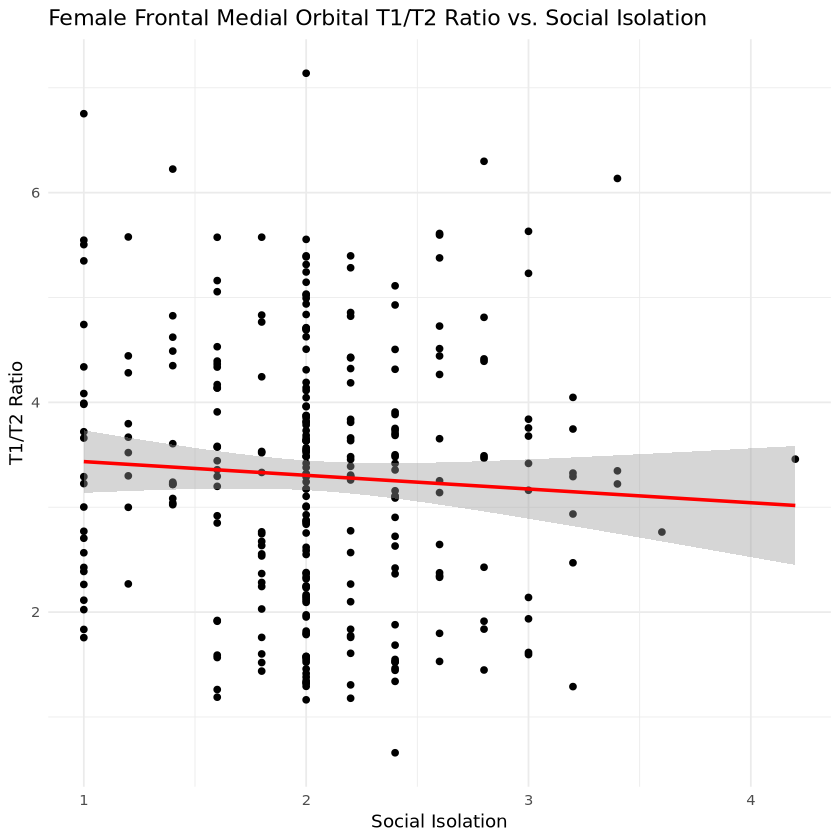

In [168]:
# Plot using ggplot2
ggplot(fmri_data_female, aes(x = pheno_social_isolation, y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio)) +
  geom_point() +  # Add points
  geom_smooth(method = "lm", col = "red") +  # Add regression line
  labs(title = "Female Frontal Medial Orbital T1/T2 Ratio vs. Social Isolation",
       x = "Social Isolation", 
       y = "T1/T2 Ratio") +
  theme_minimal()

## Males and Females Combined

In [160]:
dwi_data$pheno_msex <- factor(dwi_data$pheno_msex, 
                              levels = c(0, 1),
                              labels = c("Female", "Male"))

### Diffusivity Metrics

#### Axial Diffusivity Comparisons

`geom_smooth()` using formula = 'y ~ x'


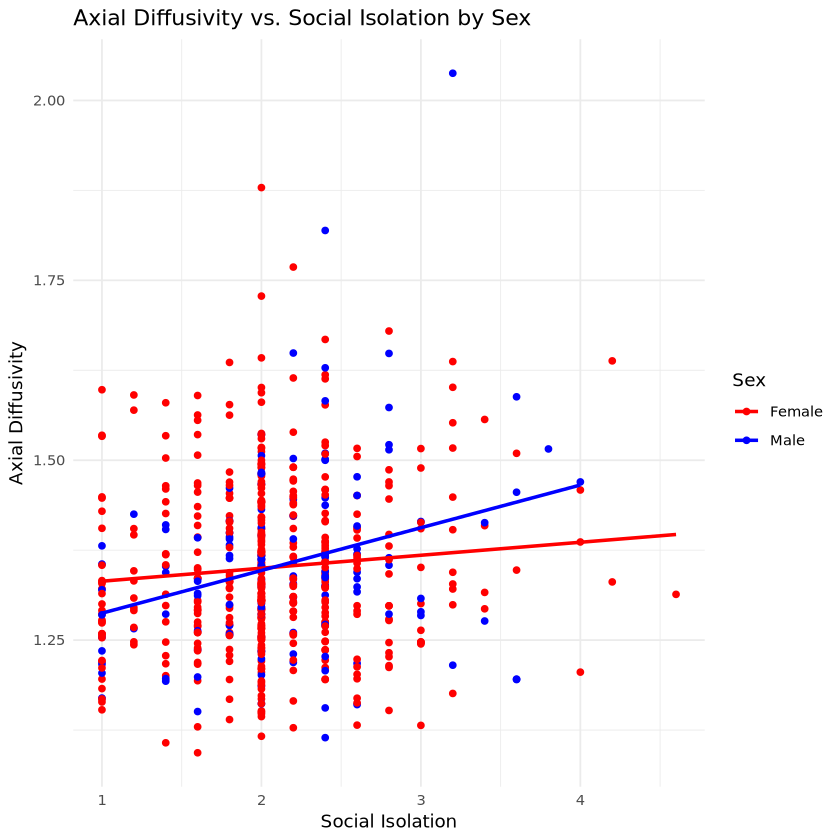

In [145]:
ggplot(dwi_data, aes(x = pheno_social_isolation, 
                     y = dwi_AAL_Frontal_Sup_Orb_R_ad,
                     color = factor(pheno_msex))) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  scale_color_manual(
    name = "Sex",
    values = c("0" = "red",  # pheno_msex == 0 -> Female
               "1" = "blue" # pheno_msex == 1 -> Male
    ),
    labels = c("Female", "Male")
  ) +
  labs(title = "Axial Diffusivity vs. Social Isolation by Sex",
       x = "Social Isolation", 
       y = "Axial Diffusivity") +
  theme_minimal()


In [161]:
# Fit the ANCOVA model using lm()
# We include an interaction term to test whether the effect of
# pheno_social_isolation on AD differs by sex
model_ancova <- lm(dwi_AAL_Frontal_Sup_Orb_R_ad ~ 
                     pheno_msex * pheno_social_isolation, 
                   data = dwi_data)

# Examine the ANOVA table
anova(model_ancova)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pheno_msex,1,0.003093623,0.003093623,0.2072636,0.6490990538
pheno_social_isolation,1,0.165333649,0.165333649,11.0768651,0.0009321523
pheno_msex:pheno_social_isolation,1,0.065612043,0.065612043,4.3958126,0.0364801601
Residuals,554,8.269022064,0.014926033,NA,NA


#### Mean Diffusivity Comparisons

`geom_smooth()` using formula = 'y ~ x'


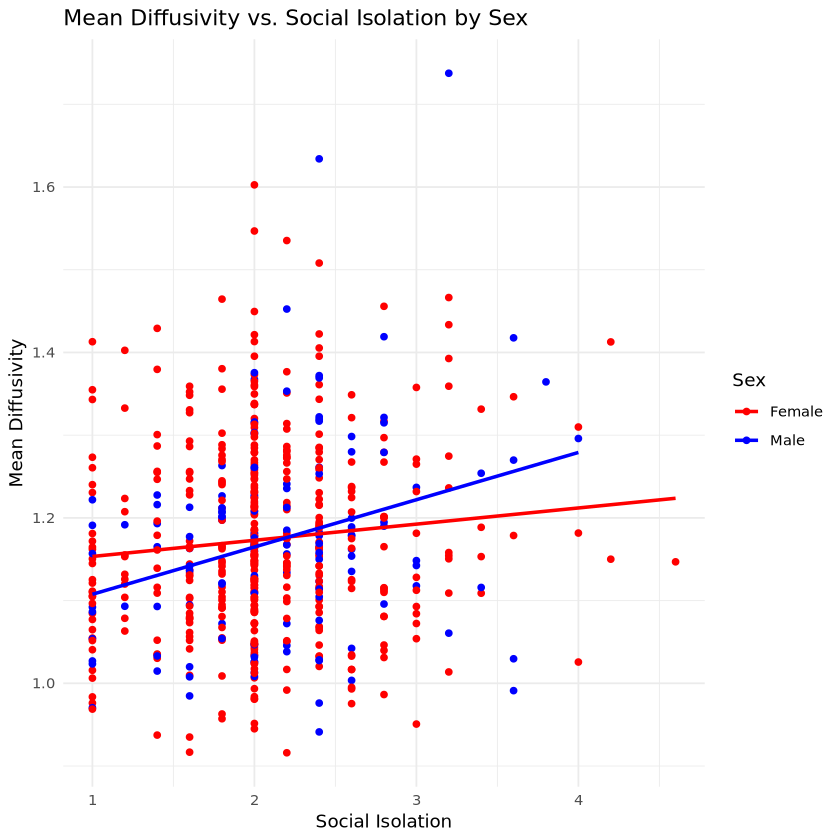

In [150]:
ggplot(dwi_data, aes(x = pheno_social_isolation, 
                     y = dwi_AAL_Frontal_Sup_Orb_R_md,
                     color = factor(pheno_msex))) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  scale_color_manual(
    name = "Sex",
    values = c("0" = "red",  # pheno_msex == 0 -> Female
               "1" = "blue" # pheno_msex == 1 -> Male
    ),
    labels = c("Female", "Male")
  ) +
  labs(title = "Mean Diffusivity vs. Social Isolation by Sex",
       x = "Social Isolation", 
       y = "Mean Diffusivity") +
  theme_minimal()


In [162]:
# Fit the ANCOVA model using lm()
# We include an interaction term to test whether the effect of
# pheno_social_isolation on AD differs by sex
model_ancova <- lm(dwi_AAL_Frontal_Sup_Orb_R_md ~ 
                     pheno_msex * pheno_social_isolation, 
                   data = dwi_data)

# Examine the ANOVA table
anova(model_ancova)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pheno_msex,1,1.168287e-07,1.168287e-07,8.526291e-06,0.9976712464
pheno_social_isolation,1,1.716665e-01,1.716665e-01,1.252842e+01,0.0004344913
pheno_msex:pheno_social_isolation,1,5.434334e-02,5.434334e-02,3.966039e+00,0.0469174267
Residuals,554,7.591002e+00,1.370217e-02,NA,NA


#### Radial Diffusivity Comparisons

**MALE VS. FEMALE PLOT**

`geom_smooth()` using formula = 'y ~ x'


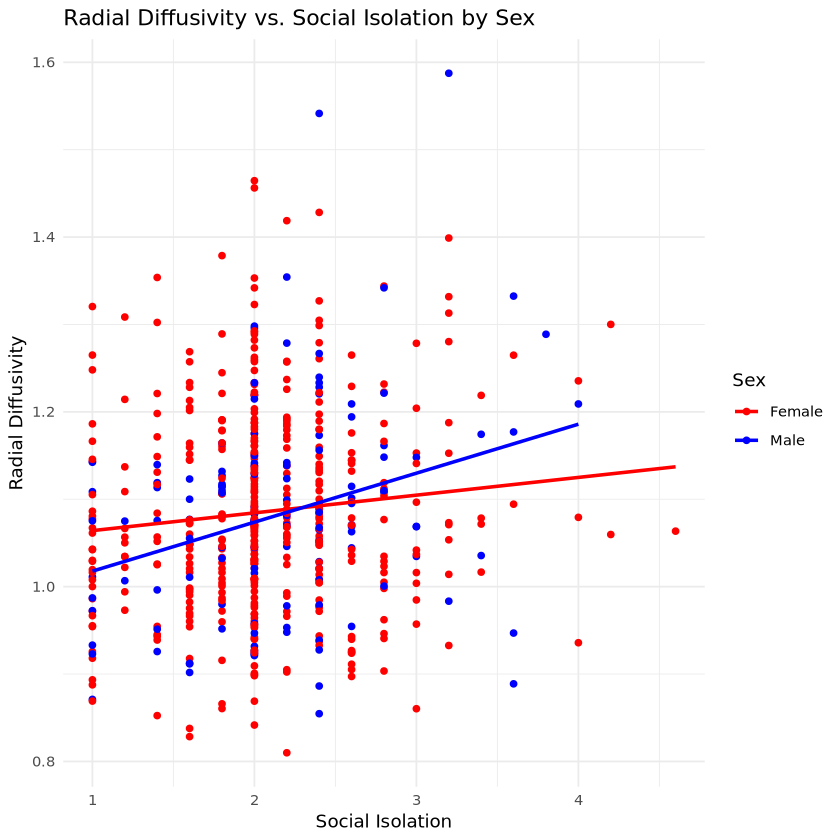

In [155]:
ggplot(dwi_data, aes(x = pheno_social_isolation, 
                     y = dwi_AAL_Frontal_Sup_Orb_R_rd,
                     color = factor(pheno_msex))) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  scale_color_manual(
    name = "Sex",
    values = c("0" = "red",  # pheno_msex == 0 -> Female
               "1" = "blue" # pheno_msex == 1 -> Male
    ),
    labels = c("Female", "Male")
  ) +
  labs(title = "Radial Diffusivity vs. Social Isolation by Sex",
       x = "Social Isolation", 
       y = "Radial Diffusivity") +
  theme_minimal()


**Radial Diffusivity Ancova**

In [163]:
# Fit the ANCOVA model using lm()
# We include an interaction term to test whether the effect of
# pheno_social_isolation on AD differs by sex
model_ancova <- lm(dwi_AAL_Frontal_Sup_Orb_R_rd ~ 
                     pheno_msex * pheno_social_isolation, 
                   data = dwi_data)

# Examine the ANOVA table
anova(model_ancova)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
pheno_msex,1,0.0007451519,0.0007451519,0.05552209,0.8138058887
pheno_social_isolation,1,0.1748776297,0.1748776297,13.03032563,0.0003342752
pheno_msex:pheno_social_isolation,1,0.0491068426,0.0491068426,3.65900516,0.0562821794
Residuals,554,7.4351332125,0.0134208181,NA,NA


### T1T2 Ratio Metrics

`geom_smooth()` using formula = 'y ~ x'


<ScaleContinuousPosition>
 Range:  
 Limits:    0 --   10

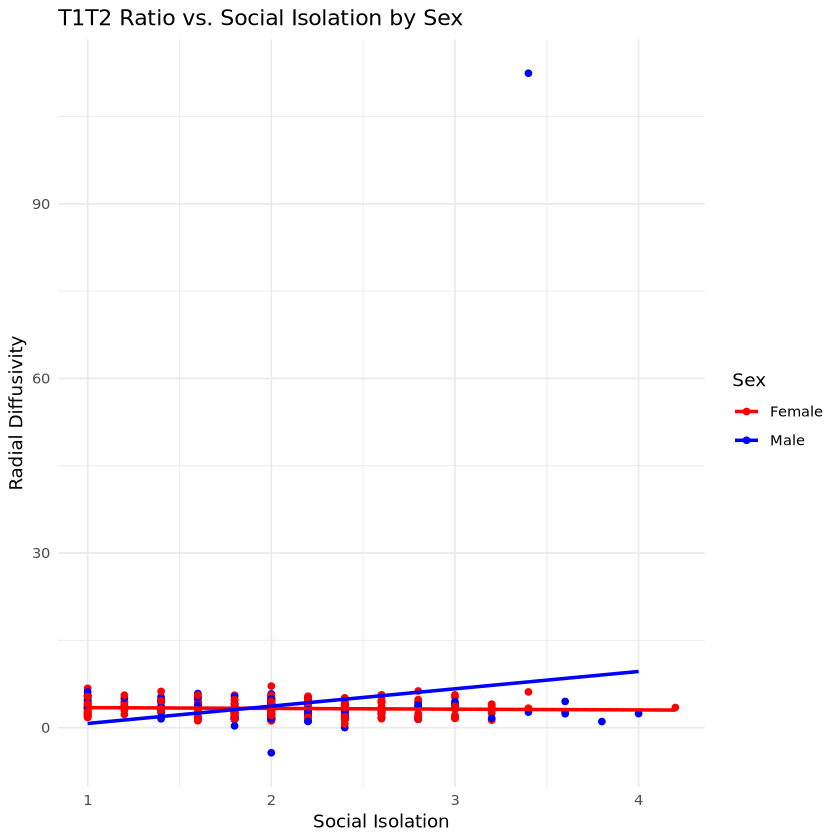

In [180]:
ggplot(fmri_data, aes(x = pheno_social_isolation, 
                     y = bold_AAL_Frontal_Med_Orb_R_t1t2ratio,
                     color = factor(pheno_msex))) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  scale_color_manual(
    name = "Sex",
    values = c("0" = "red",  # pheno_msex == 0 -> Female
               "1" = "blue" # pheno_msex == 1 -> Male
    ),
    labels = c("Female", "Male")
  ) +
  labs(title = "T1T2 Ratio vs. Social Isolation by Sex",
       x = "Social Isolation", 
       y = "Radial Diffusivity") +
  theme_minimal()
  ylim(0, 10)
